<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## San Francisco Data

---

[San Francisco provides a wealth of data on the city to the public.](https://data.sfgov.org/) Project 4 is all about exploring this data and modeling interesting relationships with regression.

Project 4 is also much more open-ended than the previous projects. You are more responsible for finding things about the data that interest you, coming up with your own hypothesis about it, and reporting on the analysis you carry out. That being said, there are still specific requirements and restrictions on the type of models you will be constructing.

---

## Notes on the data

We have gone through the above website and pulled out a variety of different datasets that we think are particularly interesting. Some of the datasets are from external sources as well, but all are related to San Francisco. A high level overview of data folders is provided after the project requirements section.

**There is a lot of different data. You are _NOT_ expected to explore all of it or include all of it in analyses.** The point of the project is to focus on aspects of San Francisco that are particularly interesting to you from a modeling point of view. 

**The uncompressed data is a large filesize.** Even the compressed data is pretty large. The data is compressed into a .7z format which has one of the smallest filesizes available. You will likely need a 3rd party app to extract it. 

### Recommended Utilities for .7z
- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.

---

## Project requirements

**You will be performing 4 different sections of analysis on the San Francisco data.**

**Models must be regression. This means that your target variable needs to be numeric/continuous**

Do not perform classification models – this will be the topic of week 4.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Choose a dataset or datasets of interest to you and perform EDA

---

1. Explain what the data is. This may include multiple csv files. Some of this data has hard to understand codes representing the variables. Nearly all data is pulled from https://data.sfgov.org/ so this is a very good resource for determining what the data is.
- Clean the data.
- Develop and state clearly a hypothesis about the data that you would want to test.
- Create some initial visualizations on the portions of the data relevant to your hypothesis.

In [21]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import patsy
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV


# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

This data set is categorical in nature so it doesn't really lend itself to the linear regression analysis but had
a lot of fun poking around with plotting on top of a map so I kept it in here anyways. 

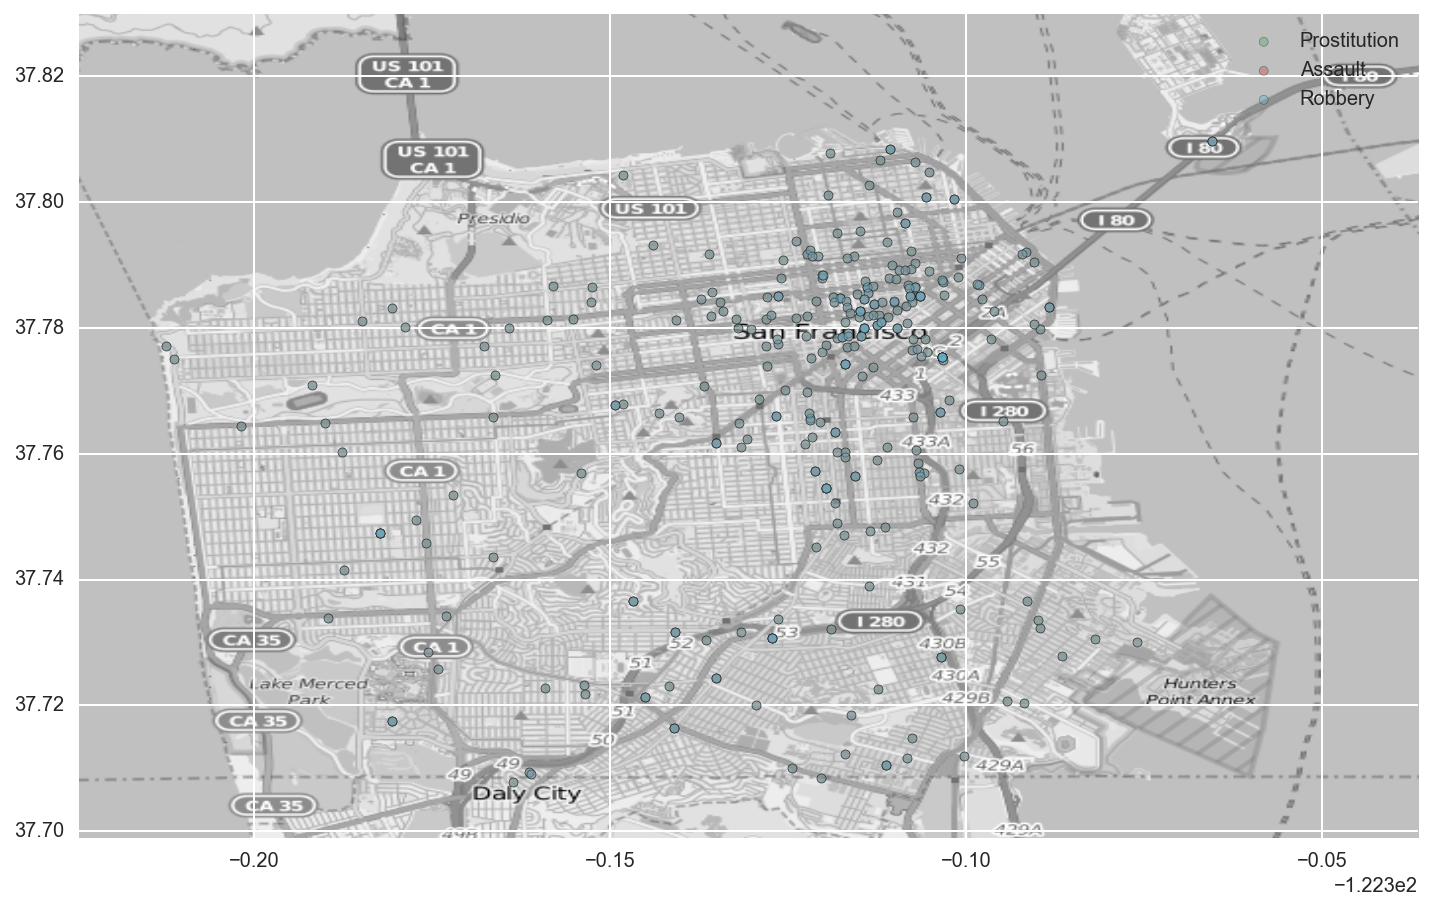

In [5]:
mapdata = np.loadtxt("/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/sf_crime/sf_map_copyright_openstreetmap_contributors.txt")
crime_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/sf_crime/sfpd_incidents_from2003.csv'
df = pd.read_csv(crime_fp)


# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

train = df

#Get rid of the bad lat/longs
train['Xok'] = train[train.X<-121].X
train['Yok'] = train[train.Y<40].Y
train = train.dropna()

trainP = train[train.Category == 'PROSTITUTION'] #Grab the prostitution crimes
train = train[1:300] #Can't use all the data and complete within 600 sec :(

plt.figure(figsize=(12,12*asp))

plt.scatter(train.Xok, train.Yok,data=train[train['Category']=='PROSTITUTION'],c=sns.color_palette()[1],alpha=0.4,label='Prostitution')
plt.scatter(train.Xok, train.Yok,data=train[train['Category']=='ASSAULT'],c=sns.color_palette()[2],alpha=0.4,label='Assault')
plt.scatter(train.Xok, train.Yok,data=train[train['Category']=='ROBBERY'],c=sns.color_palette()[5],alpha=0.4,label='Robbery')
plt.legend()

plt.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)

plt.show()

In [6]:
school_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/schools/sf_schools.csv'
zillow_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/zillow_property_sales/zillow_mediansale_persqft_neighborhood.csv'
neighborhood_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/neighborhood_analysis/sf_neighborhood_analysis.csv'
evictions_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/evictions/sf_eviction_notices.csv'
budget_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/city_budget/budget.csv'
fire_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/'
fire_inspections_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/fire_inspections.csv'
fire_incidents_fp ='/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/fire_incidents.csv'
fire_violations_fp ='/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/sf_firecode_violations.csv'
assesor_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/assessor_office/assessor_data_2007_2008.csv'
three_one_one = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/311_case_records/311_records.csv'


#zillow = pd.read_csv(zillow_fp)
#neighborhood = pd.read_csv(neighborhood_fp)
#evictions = pd.read_csv(evictions)
#budget = pd.read_csv(budget_fp)
#fire_incident = pd.read_csv(fire_incidents_fp)
#fire_inspect = pd.read_csv(fire_inspections_fp)
#fire_viol = pd.read_csv(fire_violations_fp)
assesor = pd.read_csv(assesor_fp)
#three11 = pd.read_csv(three_one_one)

assesor = pd.read_csv(assesor_fp)
assesor_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/assessor_office/assessor_data_2007_2008.csv'


//anaconda/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here are the links that have some info around the assessor data set

https://dev.socrata.com/foundry/data.sfgov.org/fk72-cxc3

http://www.opendatanetwork.com/dataset/data.sfgov.org/fk72-cxc3

In [7]:
#Loading most current years data along with class key to help with EDA
ass_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/assessor_office/assessor_data_2014_2015.csv'
ass_class_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/assessor_office/assessor_class_use_key.csv'

assesor = pd.read_csv(ass_fp)
ass_class = pd.read_csv(ass_class_fp)

//anaconda/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#Merging property type data to help with EDA
assesor = pd.merge(assesor,ass_class,how='inner',left_on='RP1CLACDE',right_on='CLASS')

#Choosing some of the columns I may want to mess around with
cols = ['DESC.1','DESC','KITCHEN','RP1CLACDE','BATHS','BEDS','ROOMS','UNITS','STOREYNO','LAREA','RP1FXTVAL','RP1IMPVAL','RP1LNDVAL','RP1PPTVAL']
cont_column = ['KITCHEN', 'BATHS','BEDS','ROOMS','UNITS','STOREYNO','LAREA','RP1FXTVAL','RP1IMPVAL','RP1LNDVAL','RP1PPTVAL']

assesor.describe().T

//anaconda/envs/dsi/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count           mean           std    min      25%       50%  \
BASELOT     198332.0       0.629071  1.666449e+01    0.0      0.0       0.0   
RP1VOLUME   198332.0      21.132631  1.300533e+01    1.0     10.0      20.0   
YRBLT       198332.0    1762.245956  5.667966e+02    0.0   1908.0    1929.0   
BATHS       198332.0       1.857648  7.257967e+00    0.0      1.0       1.0   
BEDS        198332.0       1.081031  1.100632e+01    0.0      0.0       0.0   
ROOMS       198332.0       6.343520  2.065889e+01   -7.0      4.0       5.0   
STOREYNO    198332.0       1.483281  8.431342e+00   -1.0      1.0       1.0   
UNITS       198332.0       1.248810  1.434814e+01    0.0      1.0       1.0   
CHGDATE     198332.0    7070.122567  4.284009e+03    0.0   1304.0    9804.0   
BUILTIN     198332.0       0.001382  6.152536e-01    0.0      0.0       0.0   
DEPTH       198332.0       8.104740  2.115145e+01    0.0      0.0       0.0   
FRONT       198332.0       0.067627  1.759638e+00    0.0      0.0       0.0   
SQFT        198332.0    2528.773647  1.823690e+04    0.0    964.0    1362.0   
FBA         198332.0      65.452252  3.658020e+02 -883.0      0.0       0.0   
LAREA       198332.0    3615.175059  1.372430e+05    0.0      0.0    2469.0   
REPRISDATE       0.0            NaN           NaN    NaN      NaN       NaN   
RP1RECDAT1  198332.0  276882.558316  3.505481e+05    0.0  70112.0  111018.0   
RP1DOCNO2   198332.0     249.782138  5.001901e+02    0.0      0.0       0.0   
RP1TRACDE   197698.0     996.228009  7.012619e+01    1.0      NaN       NaN   
OWNRPRCNT   198332.0       0.881016  2.410041e-01    0.0      1.0       1.0   
RP1EXMVL2   198332.0   27020.004931  1.409263e+06    0.0      0.0       0.0   
RP1EXMVL1   198332.0    3226.833743  4.191780e+03    0.0      0.0       0.0   
ROLLYEAR    198332.0      14.000000  0.000000e+00   14.0     14.0      14.0   
RECURRSALD  198332.0  212035.753318  3.570676e+05    0.0      0.0   40701.0   
RP1FXTVAL   198332.0    8138.862564  6.126106e+05    0.0      0.0       0.0   
RP1IMPVAL   198332.0  450511.670320  5.250319e+06    0.0  82906.0  189858.0   
RP1LNDVAL   198332.0  435007.851481  3.026967e+06    0.0  52220.0  212541.0   
RP1PPTVAL   198332.0   40736.215780  1.709738e+06    0.0      0.0       0.0   

                 75%           max  
BASELOT          0.0  9.370000e+02  
RP1VOLUME       32.0  4.500000e+01  
YRBLT         1959.0  8.687000e+03  
BATHS            2.0  1.002000e+03  
BEDS             2.0  3.800000e+03  
ROOMS            7.0  3.606000e+03  
STOREYNO         2.0  9.990000e+02  
UNITS            1.0  4.000000e+03  
CHGDATE       9908.0  9.912000e+03  
BUILTIN          0.0  2.740000e+02  
DEPTH            0.0  9.996000e+01  
FRONT            0.0  9.939000e+01  
SQFT          2035.0  3.015837e+06  
FBA              0.0  7.387800e+04  
LAREA         3000.0  5.800145e+07  
REPRISDATE       NaN           NaN  
RP1RECDAT1  140829.0  9.912310e+05  
RP1DOCNO2      458.0  9.999000e+03  
RP1TRACDE        NaN  9.000000e+03  
OWNRPRCNT        1.0  1.000000e+00  
RP1EXMVL2        0.0  3.402074e+08  
RP1EXMVL1     7000.0  5.320000e+05  
ROLLYEAR        14.0  1.400000e+01  
RECURRSALD  130603.0  9.912310e+05  
RP1FXTVAL        0.0  1.637157e+08  
RP1IMPVAL   330548.0  6.661127e+08  
RP1LNDVAL   427243.5  2.791691e+08  
RP1PPTVAL        0.0  1.448832e+08

Some of this data doesn't quite smell right. The property values RP1PPTVAL 25-75 being 0 is odd. I was planning on 
using that as my target variable... Need to dig into this a bit more.

In [9]:
mask = (assesor.RP1PPTVAL == 0)
assesor.loc[mask,cols].groupby(['DESC','DESC.1'])[cont_column].agg(['mean','std','count']).reset_index()

DESC                                    DESC.1  \
                                                                          
0            Commercial Hotel                                     Hotel   
1            Commercial Hotel                Hotel Commercial (H2w/Com)   
2            Commercial Hotel                            Hotels - Other   
3            Commercial Hotel                                    Motels   
4            Commercial Hotel                   Residential Hotel & SRO   
5            Commercial Hotel                            Retail & Hotel   
6             Commercial Misc               Apartmnt & Commercial Store   
7             Commercial Misc               Churches,Convents,Rectories   
8             Commercial Misc      Clubs,Lodges,Fraternal Organizations   
9             Commercial Misc                Convalescent/Nursing Homes   
10            Commercial Misc                        Garage Condominium   
11            Commercial Misc                      Garages (Commercial)   
12            Commercial Misc                               Gas Station   
13            Commercial Misc                               Golf Course   
14            Commercial Misc                                 Hospitals   
15            Commercial Misc                                 Mixed use   
16            Commercial Misc            PUD (Planned Unit Development)   
17            Commercial Misc                               Parking Lot   
18            Commercial Misc                 Parking Stall Condominium   
19            Commercial Misc                                   Schools   
20            Commercial Misc                                  Theatres   
21            Commercial Misc                     Time Share Fractional   
22            Commercial Misc                                 Timeshare   
23          Commercial Office           Medical- dental Office Building   
24          Commercial Office                                    Office   
25          Commercial Office                 Office - "Trophy" Class A   
26          Commercial Office                      Office - Condominium   
27          Commercial Office                     Office - High Class A   
28          Commercial Office                     Office - High Class B   
29          Commercial Office                     Office - High Class C   
..                        ...                                       ...   
46                 Industrial                       Industial Warehouse   
47                 Industrial                                Industrial   
48                 Industrial                    Industrial Condominium   
49                 Industrial                    Industrial Data Center   
50                 Industrial                Industrial Mixed/Other Use   
51    Miscellaneous/Mixed-Use                                      Misc   
52    Miscellaneous/Mixed-Use                               Mission Bay   
53    Miscellaneous/Mixed-Use                           Under Water Lot   
54    Miscellaneous/Mixed-Use                                Vacant Lot   
55    Miscellaneous/Mixed-Use                 Vacant Lot - Restrictions   
56   Multi-Family Residential              1 Flat & 1 Apt Bldg-1 Parcel   
57   Multi-Family Residential                1 Flat & Dwelling-1 Parcel   
58   Multi-Family Residential                 2 Dwellings on One Parcel   
59   Multi-Family Residential                                 Apartment   
60   Multi-Family Residential                   Coop Units Unsegregated   
61   Multi-Family Residential                    Dwellings - Apartments   
62   Multi-Family Residential                              Flat & Store   
63   Multi-Family Residential                            Flats & Duplex   
64   Multi-Family Residential                     Office and Apartments   
65   Multi-Family Residential  Single Struct on Multi Lot(D & F's only)   
66   Multi-Family Residential                     

In [10]:
assesor[(assesor.RP1PPTVAL == 0) & (assesor['DESC.1'] == 'Dwelling')]

PROPLOC RP1NBRCDE  RP1PRCLID  BASELOT  \
5432    0000 0714 NORTH POINT         ST0000       08E   0024 006        0   
5433    0000 0836 BAY                 ST0000       08E   0026 012        0   
5434    0000 0844 BAY                 ST0000       08E   0026 014        0   
5435    0000 0875 NORTH POINT         ST0000       08E  0026 019A        0   
5436    0000 0869 NORTH POINT         ST0000       08E  0026 019B        0   
5437    0000 0839 NORTH POINT         ST0000       08E   0026 023        0   
5438    0000 0025 BERGEN              AL0000       08E   0026 027        0   
5439    0000 0022 BERGEN              ST0000       08E   0026 036        0   
5440    0000 0740 BAY                 ST0000       08E   0027 008        0   
5441    0000 2626 HYDE                ST0000       08E   0027 012        0   
5442    0000 0767 NORTH POINT         ST0000       08E   0027 023        0   
5443    0000 0680 BAY                 ST0000       08E  0028 006D        0   
5444    0000 0690 BAY                 ST0000       08E  0028 006I        0   
5445    0000 0276 FRANCISCO           ST0000       08G   0039 015        0   
5446    0000 0284 FRANCISCO           ST0000       08G   0039 017        0   
5447    0000 0474 FRANCISCO           ST0000       08D   0041 012        0   
5448    0000 0015 VANDEWATER          ST0000       08D   0041 018        0   
5449    0000 0740 FRANCISCO           ST0000       08E  0044 002A        0   
5450    0734 0732 FRANCISCO           ST0000       08E  0044 002C        0   
5451    0000 0025 BRET HARTE          TE0000       08E  0044 003B        0   
5452    0000 2500 LEAVENWORTH         ST0000       08E   0044 005        0   
5453    0000 2502 LEAVENWORTH         ST0000       08E   0044 006        0   
5454    0000 2504 LEAVENWORTH         ST0000       08E   0044 007        0   
5455    0000 2544 LEAVENWORTH         ST0000       08E   0044 023        0   
5456    0000 2540 LEAVENWORTH         ST0000       08E   0044 043        0   
5457    0000 2508 LEAVENWORTH         ST0000       08E   0044 044        0   
5458    0000 0800 FRANCISCO           ST0000       08E  0045 002A        0   
5459    0000 0828 FRANCISCO           ST0000       08E   0045 003        0   
5460    0000 0850 FRANCISCO           ST0000       08E   0045 005        0   
5461    0000 0864 FRANCISCO           ST0000       08E   0045 006        0   
...                                      ...       ...        ...      ...   
100879  0000 0120 CONRAD              ST0000       05A   7553 041        0   
100880  0000 0233 ARBOR               ST0000       05A   7553 044        0   
100881  0000 0227 ARBOR               ST0000       05A   7553 045        0   
100882  0000 0221 ARBOR               ST0000       05A   7553 046        0   
100883  0000 0101 ARBOR               ST0000       05A   7553 047        0   
100884  0000 0102 CONRAD              ST0000       05A   7553 048        0   
100885  0000 0010 HILIRITAS           AV0000       05A   7554 001        0   
100886  0000 0030 HILIRITAS           AV0000       05A   7554 002        0   
100887  0000 0064 HILIRITAS           AV0000       05A   7554 003        0   
100888  0000 0050 HILIRITAS           AV0000       05A   7554 004        0   
100889  0000 0000 V                     0000       05A   7554 007        0   
100890  0000 0264 ARBOR               ST0000       05A   7554 008        0   
100891  0000 5745 DIAMOND HEIGHTS     BL0000       05A   7554 020        0   
100892  0000 5735 DIAMOND HEIGHTS     BL0000       05A   7554 021        0   
100893  0000 5725 DIAMOND HEIGHTS     BL0000       05A   7554 022        0   
100894  0000 5715 DIAMOND HEIGHTS     BL0000       05A   7554 023        0   
100895  0000 5705 DIAMOND HEIGHTS     BL0000       05A   7554 024        0   
100896  0000 0060 HILIRITAS           AV0000       05A   7554 025        0   
100897  0000 0070 HILIRITAS           AV0000       05A   7554 026        0   
100898  0000 0300 SUSSEX              ST0000       05A   75

There is some odd stuff in here. Houses without bedrooms for example. Not feeling great about these records with no
property value.

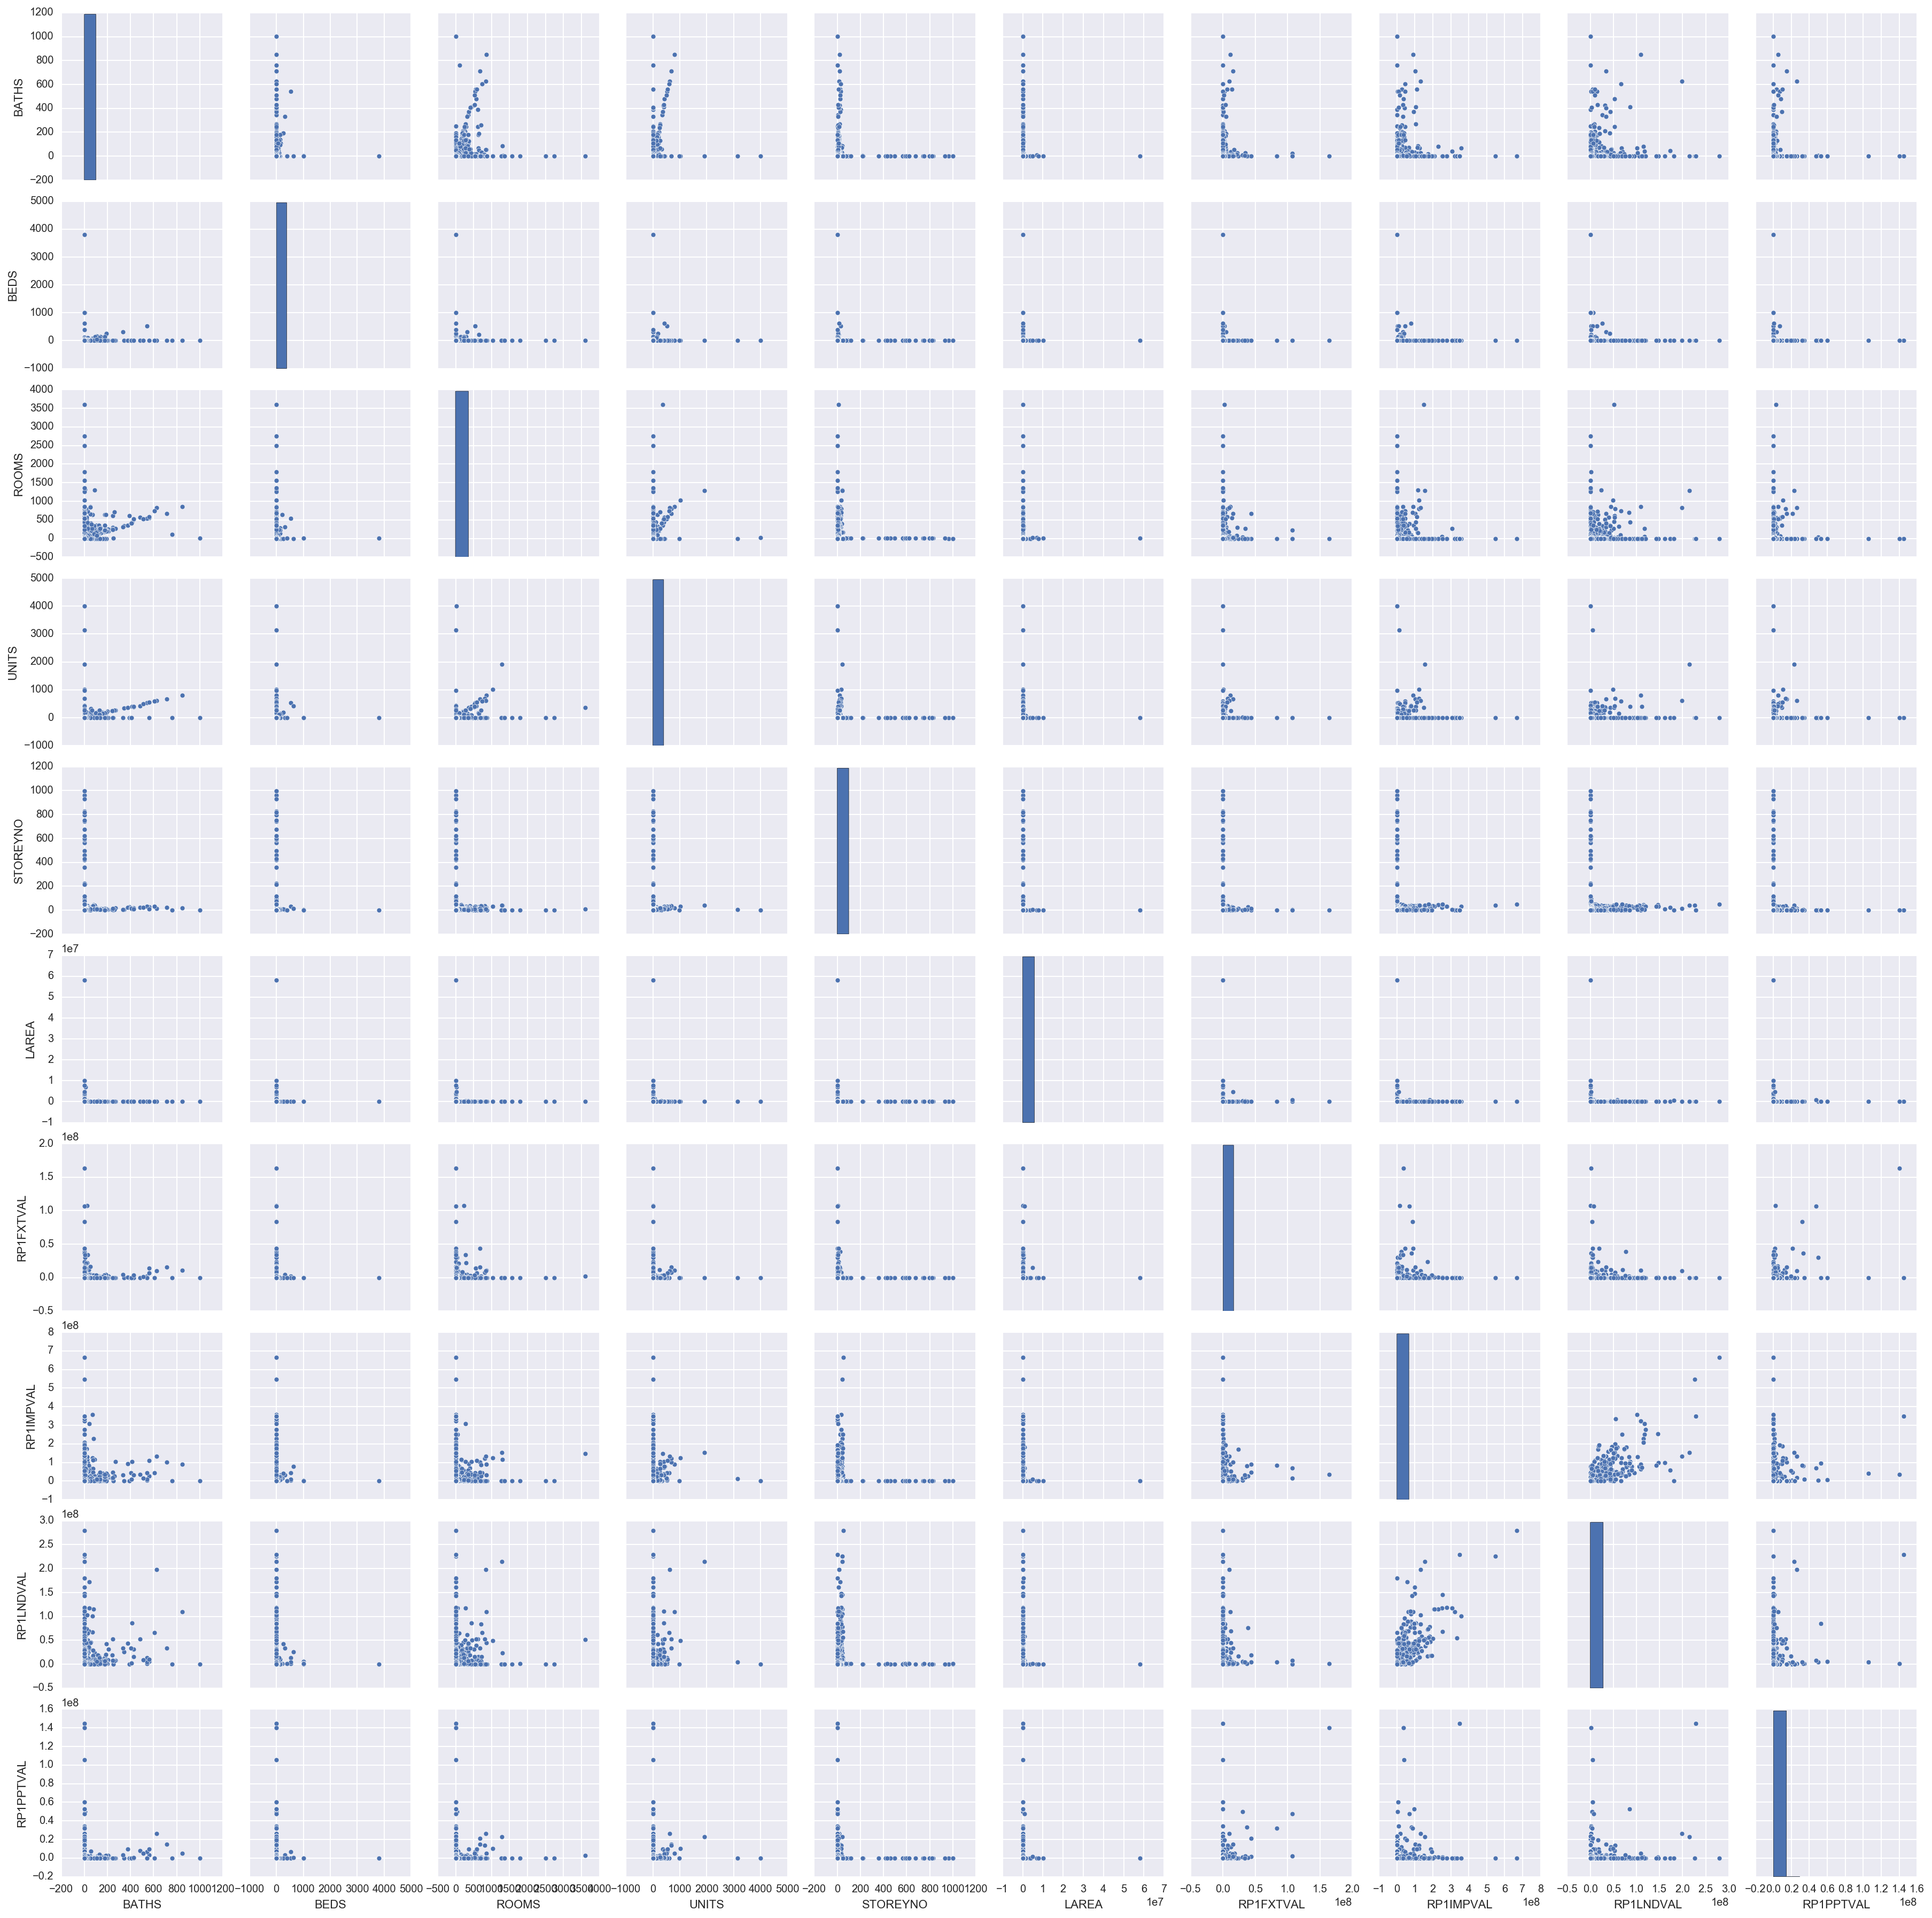

In [11]:
sns.pairplot(assesor.loc[:,cont_column])

In [12]:
#Having $values is not doing me any favors vizualizing the data. Going to pair back columns taking log of $
# and normalizing variables (will need this for regularization anyways...)
assesor['log_land'] = assesor['RP1LNDVAL'].map(lambda x: np.log(1+x))
assesor['log_prop'] = assesor['RP1PPTVAL'].map(lambda x: np.log(1+x))

my_cols = ['BATHS','BEDS','ROOMS','UNITS','STOREYNO','LAREA','RP1LNDVAL','RP1PPTVAL','log_land','log_prop']

ss = StandardScaler()
ass_n = pd.DataFrame(ss.fit_transform(assesor.loc[:,my_cols]),columns=my_cols)
assesor.head()

PROPLOC RP1NBRCDE RP1PRCLID  BASELOT  \
0  0000 0000                       0000       08H  0001 001        0   
1  0000 0000                       0000       08H  0002 001        0   
2  0000 0000                       0000       08H  0005 001        0   
3  0000 0000                       0000       08H  0006 001        0   
4  0000 0000                       0000       08H  0007 001        0   

  BASELOTSFX  RP1VOLUME RP1CLACDE  YRBLT  BATHS  BEDS    ...     RP1FXTVAL  \
0        NaN          1         G   1900      0     0    ...             0   
1        NaN          1         G   1900      0     0    ...             0   
2        NaN          1         G   1900      0     0    ...             0   
3        NaN          1         G   1900      0     0    ...             0   
4        NaN          1         G   1900      0     0    ...             0   

   RP1IMPVAL  RP1LNDVAL  RP1PPTVAL   USE             DESC  CLASS  \
0          0          0          0  COMM  Commercial Misc      G   
1          0          0          0  COMM  Commercial Misc      G   
2          0          0          0  COMM  Commercial Misc      G   
3          0          0          0  COMM  Commercial Misc      G   
4          0          0          0  COMM  Commercial Misc      G   

                 DESC.1 log_land  log_prop  
0  Garages (Commercial)      0.0       0.0  
1  Garages (Commercial)      0.0       0.0  
2  Garages (Commercial)      0.0       0.0  
3  Garages (Commercial)      0.0       0.0  
4  Garages (Commercial)      0.0       0.0  

[5 rows x 47 columns]

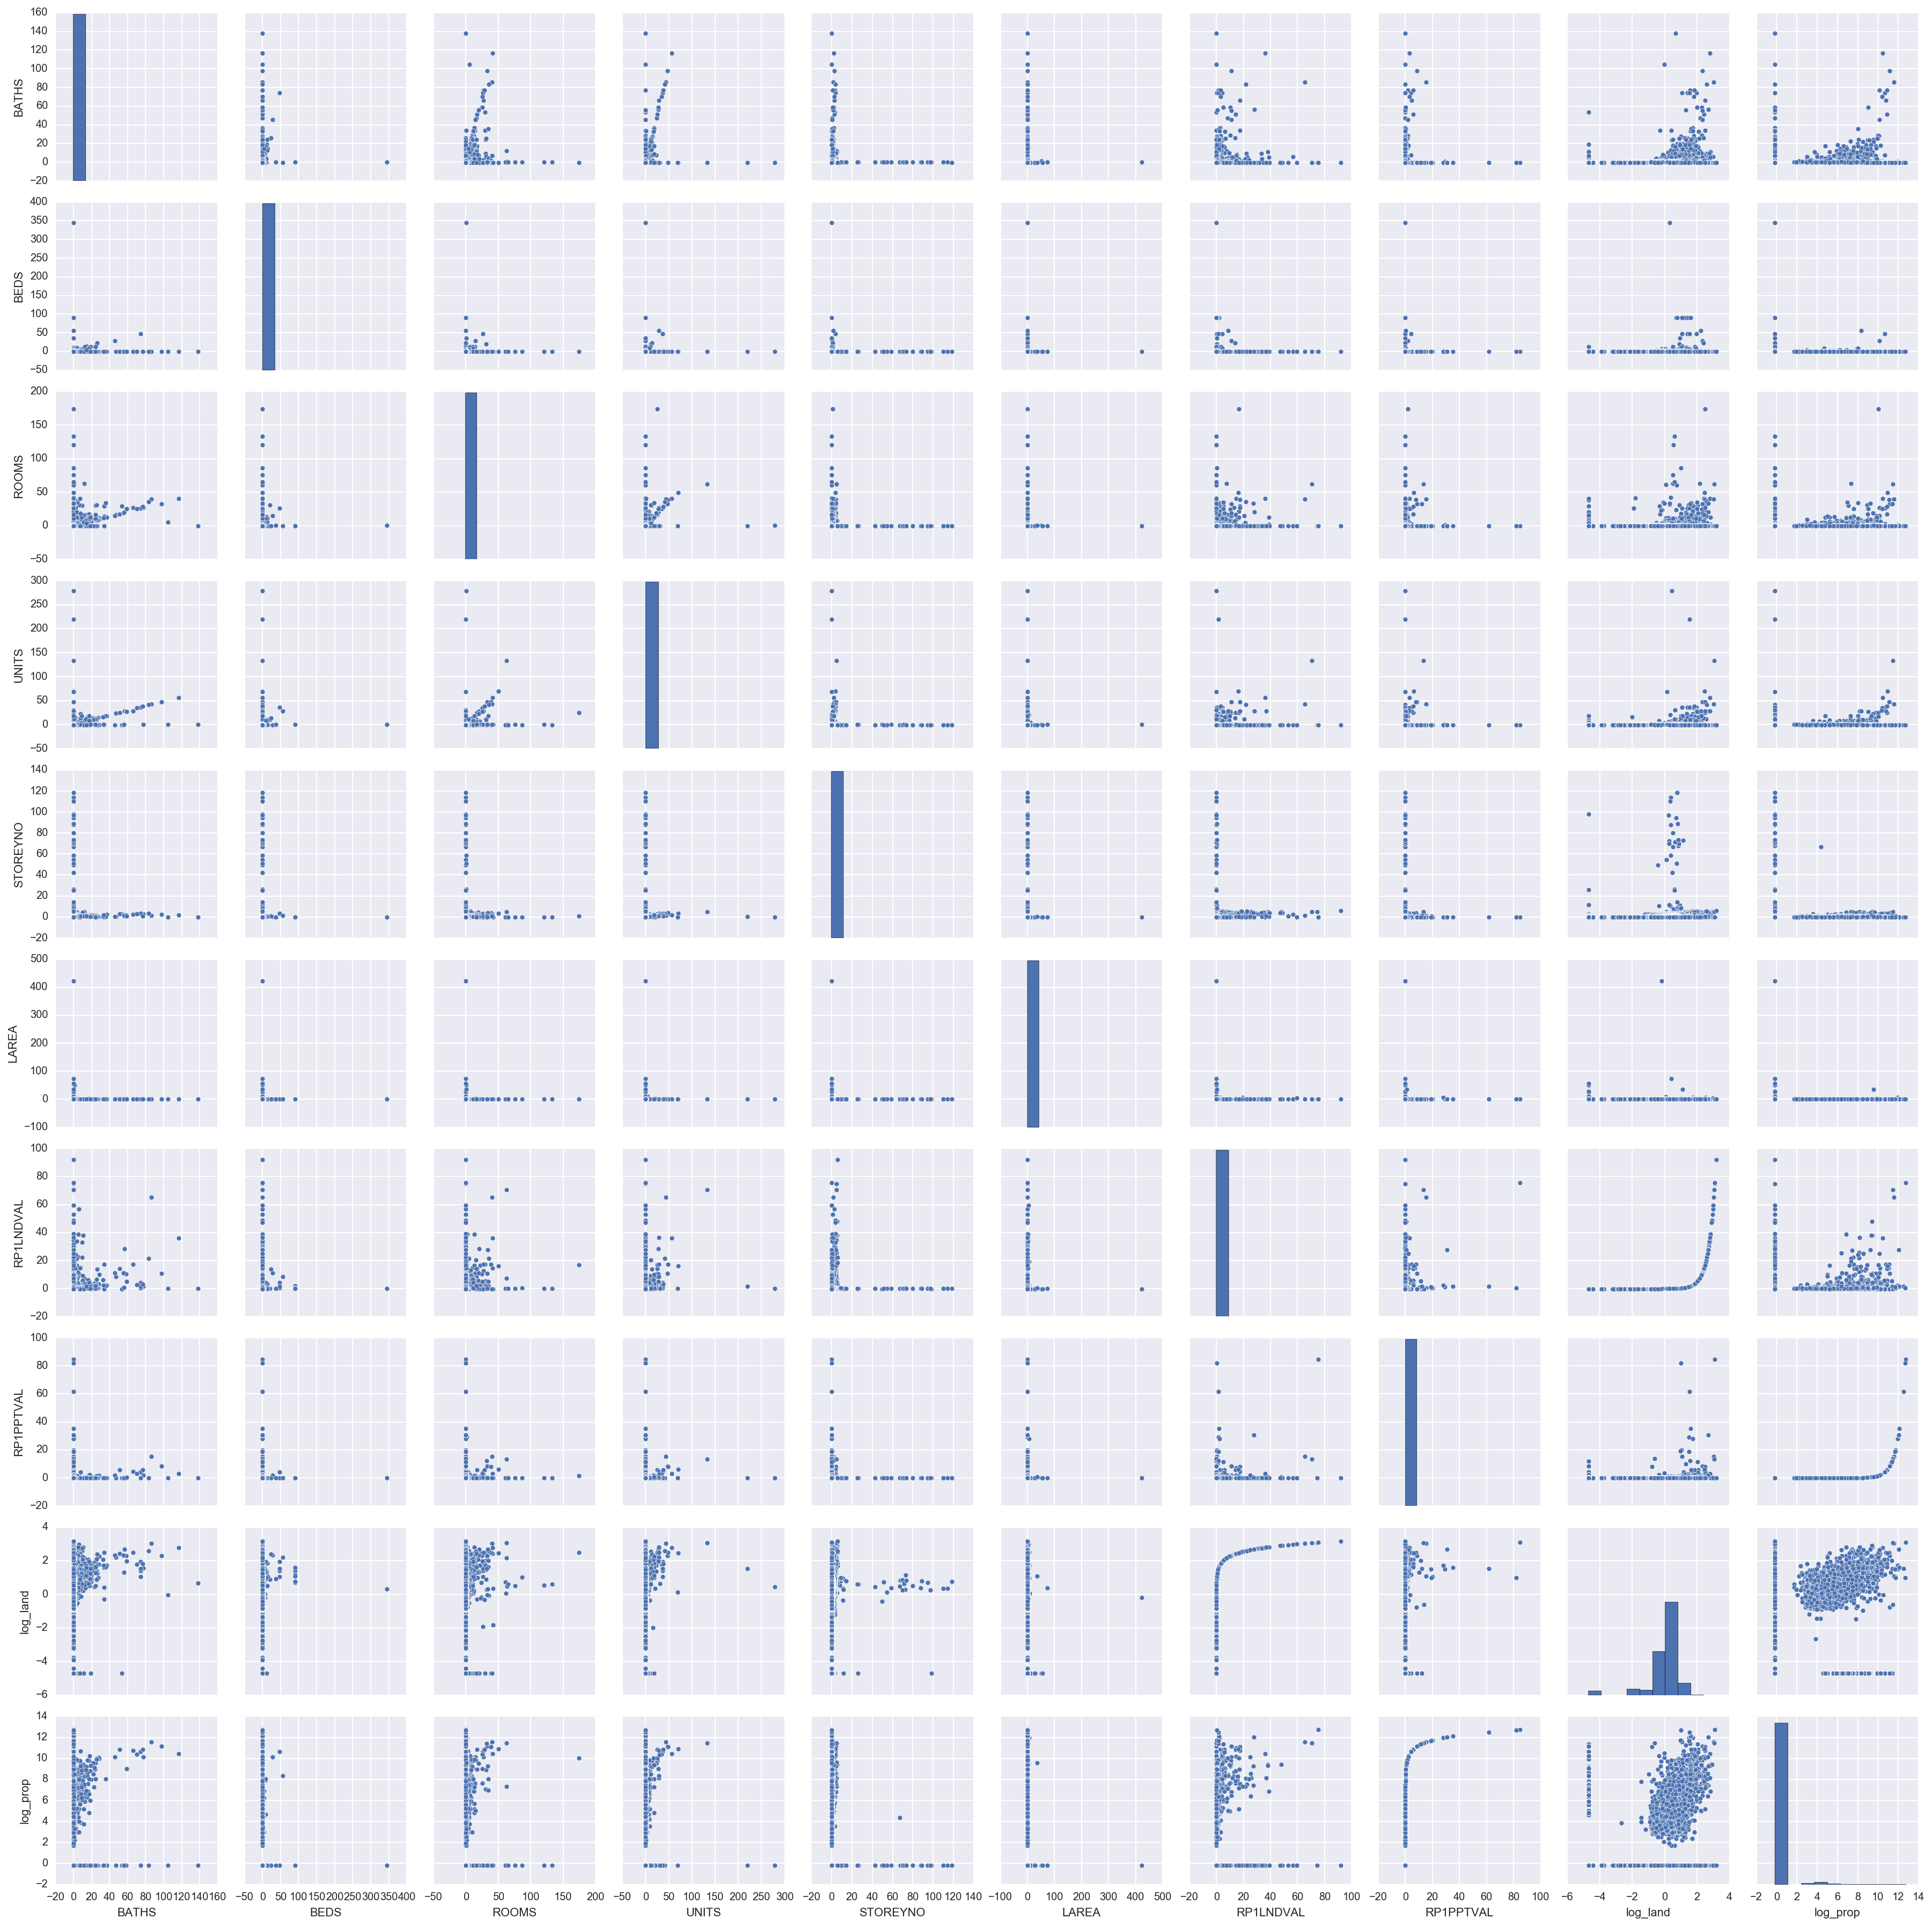

In [13]:
sns.pairplot(ass_n)

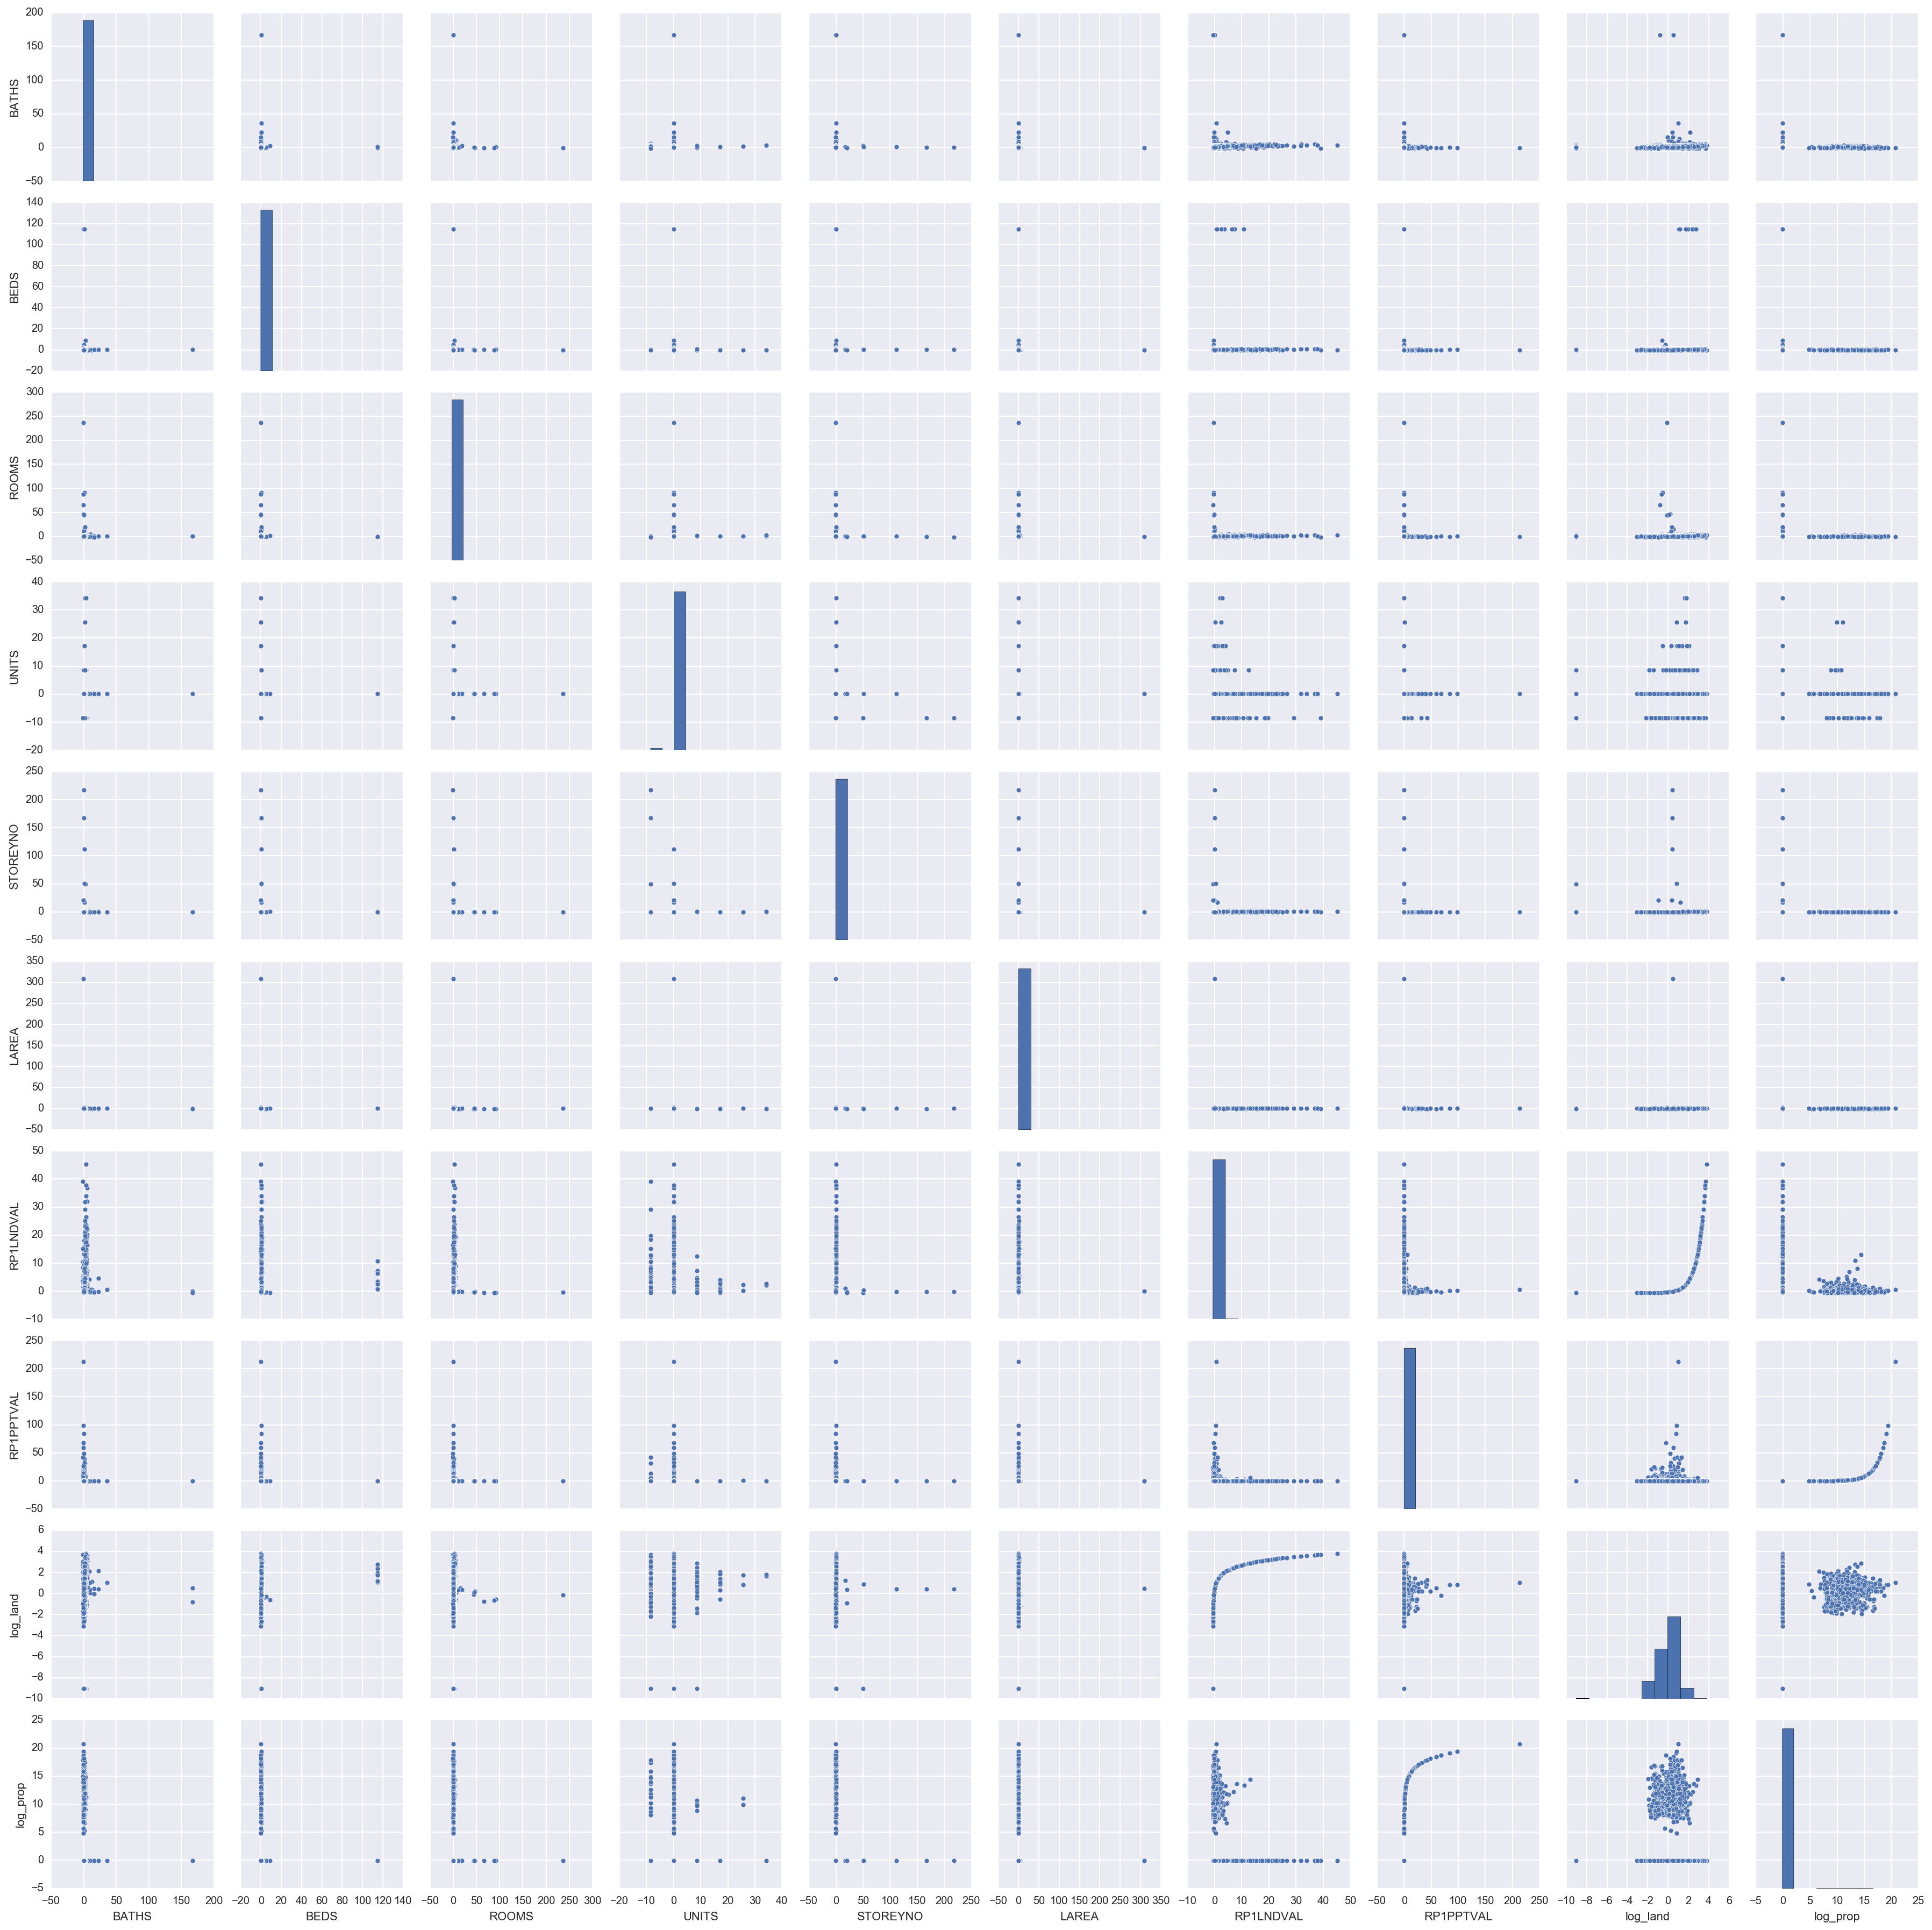

In [14]:
#Still can't tell shit from this. Too much disparity in features between say hotel and house.
#Going to subset the data and start to take a look at just residential homes. 
mask = (assesor.CLASS == 'D')
ass_n = pd.DataFrame(ss.fit_transform(assesor.loc[mask,my_cols]),columns=my_cols)
sns.pairplot(ass_n)

In [15]:
#There are some nasty outliers for beds, rooms, and baths. Going to look at houses that don't have 10 or more
#beds, baths, or rooms.

mask = (assesor.CLASS == 'D') & (assesor.BEDS < 10) & (assesor.ROOMS < 10) & (assesor.BATHS < 10) 
df2 = assesor.loc[mask,:]
df2.describe().T

count           mean            std     min           25%  \
BASELOT     90306.0       0.330831      13.053126     0.0      0.000000   
RP1VOLUME   90306.0      25.805517      11.544694     1.0     16.000000   
YRBLT       90306.0    1927.328627     119.949067     0.0   1922.000000   
BATHS       90306.0       1.555157       0.771924     0.0      1.000000   
BEDS        90306.0       0.938210       1.486060     0.0      0.000000   
ROOMS       90306.0       5.974387       1.457828    -7.0      5.000000   
STOREYNO    90306.0       1.263703       4.159292     0.0      1.000000   
UNITS       90306.0       0.990001       0.104384     0.0      1.000000   
CHGDATE     90306.0    8579.542932    3067.309983     0.0   9606.000000   
BUILTIN     90306.0       0.000000       0.000000     0.0      0.000000   
DEPTH       90306.0      10.578373      23.683577     0.0      0.000000   
FRONT       90306.0       0.027848       0.952452     0.0      0.000000   
SQFT        90306.0    1523.187197     582.579070     0.0   1140.000000   
FBA         90306.0      89.282916     218.304629  -883.0      0.000000   
LAREA       90306.0    2890.185757   33542.758882     0.0   2374.000000   
REPRISDATE      0.0            NaN            NaN     NaN           NaN   
RP1RECDAT1  90306.0  300543.867805  368317.464668     0.0  60721.000000   
RP1DOCNO2   90306.0     212.662359     460.556070     0.0      0.000000   
RP1TRACDE   90283.0    1000.304675       2.280555  1000.0           NaN   
OWNRPRCNT   90306.0       0.886869       0.223684     0.0      1.000000   
RP1EXMVL2   90306.0     832.863708   34088.229973     0.0      0.000000   
RP1EXMVL1   90306.0    4375.337907    3389.085167     0.0      0.000000   
ROLLYEAR    90306.0      14.000000       0.000000    14.0     14.000000   
RECURRSALD  90306.0  259129.581324  394127.080662     0.0      0.000000   
RP1FXTVAL   90306.0      19.795462    4785.740391     0.0      0.000000   
RP1IMPVAL   90306.0  197375.532811  193708.561283     0.0  77983.000000   
RP1LNDVAL   90306.0  279833.466281  341589.381388     0.0  48041.000000   
RP1PPTVAL   90306.0      14.046963     607.828006     0.0      0.000000   
log_land    90306.0      11.902786       1.281772     0.0     10.779831   
log_prop    90306.0       0.042984       0.537600     0.0      0.000000   

                      50%            75%           max  
BASELOT          0.000000       0.000000  9.370000e+02  
RP1VOLUME       22.000000      37.000000  4.400000e+01  
YRBLT         1935.000000    1947.000000  5.953000e+03  
BATHS            1.000000       2.000000  9.000000e+00  
BEDS             0.000000       2.000000  8.000000e+00  
ROOMS            6.000000       7.000000  9.000000e+00  
STOREYNO         1.000000       1.000000  9.630000e+02  
UNITS            1.000000       1.000000  3.000000e+00  
CHGDATE       9907.000000    9908.000000  9.912000e+03  
BUILTIN          0.000000       0.000000  0.000000e+00  
DEPTH            0.000000       0.000000  9.987000e+01  
FRONT            0.000000       0.000000  7.778000e+01  
SQFT          1400.000000    1802.000000  2.000400e+04  
FBA              0.000000       0.000000  7.558000e+03  
LAREA         2622.000000    3000.000000  1.007500e+07  
REPRISDATE            NaN            NaN           NaN  
RP1RECDAT1  111021.000000  740106.000000  9.912310e+05  
RP1DOCNO2        0.000000     366.000000  9.999000e+03  
RP1TRACDE             NaN            NaN  1.019000e+03  
OWNRPRCNT        1.000000       1.000000  1.000000e+00  
RP1EXMVL2        0.000000       0.000000  5.183760e+06  
RP1EXMVL1     7000.000000    7000.000000  1.400000e+04  
ROLLYEAR        14.000000      14.000000  1.400000e+01  
RECURRSALD   31114.000000  870130.000000  9.912300e+05  
RP1FXTVAL        0.000000       0.000000  1.435567e+06  
RP1IMPVAL   156134.000000  257484.750000  9.754485e+06  
RP1LNDVAL   194930.000000  394482.000000  2.047212e+07  
RP1PPTVAL        0.000000       0.000000  1.305270e+05  
log_land        12.180401      12.8

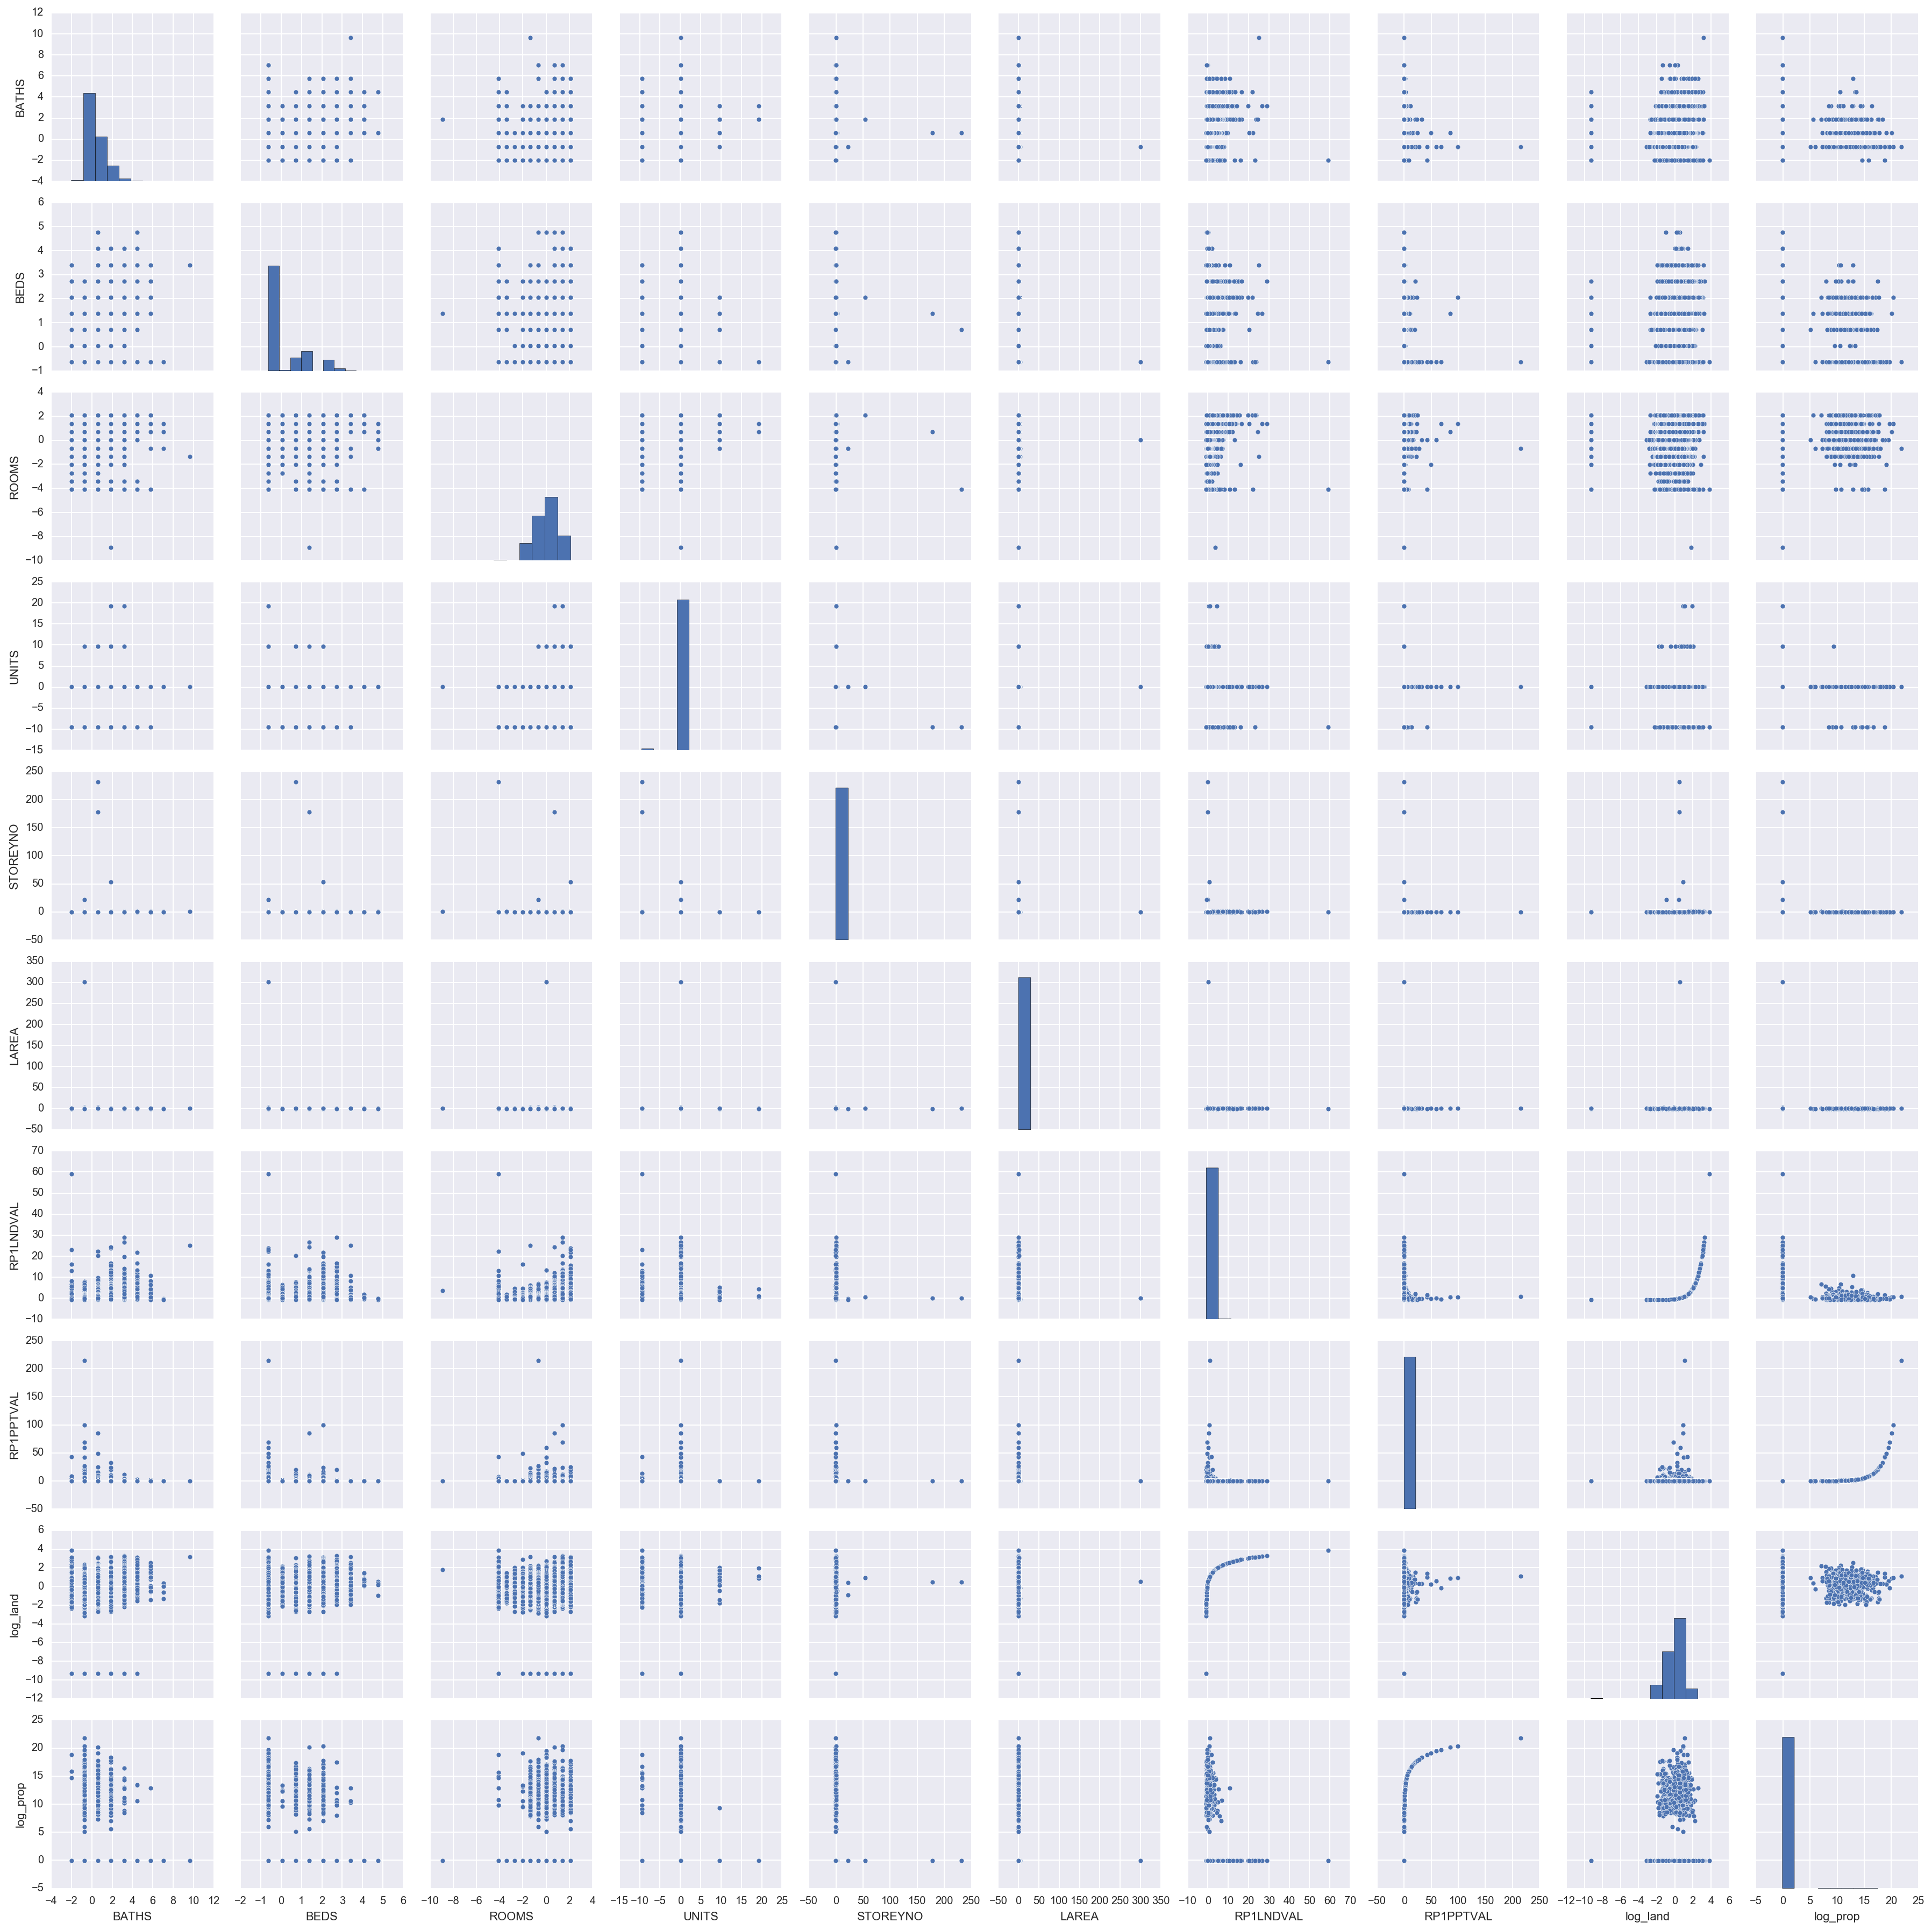

In [16]:
ass_n = pd.DataFrame(ss.fit_transform(df2.loc[mask,my_cols]),columns=my_cols)
sns.pairplot(ass_n)

In [17]:
#I cant make heads or tails of why a house would have 0 personal property value. 

#My hypothesis is that I can use beds, baths, rooms, and sqft to predict the land value. 
int_col = ['BATHS','BEDS','ROOMS','SQFT','RP1LNDVAL']
df3 = df2.loc[:,int_col]

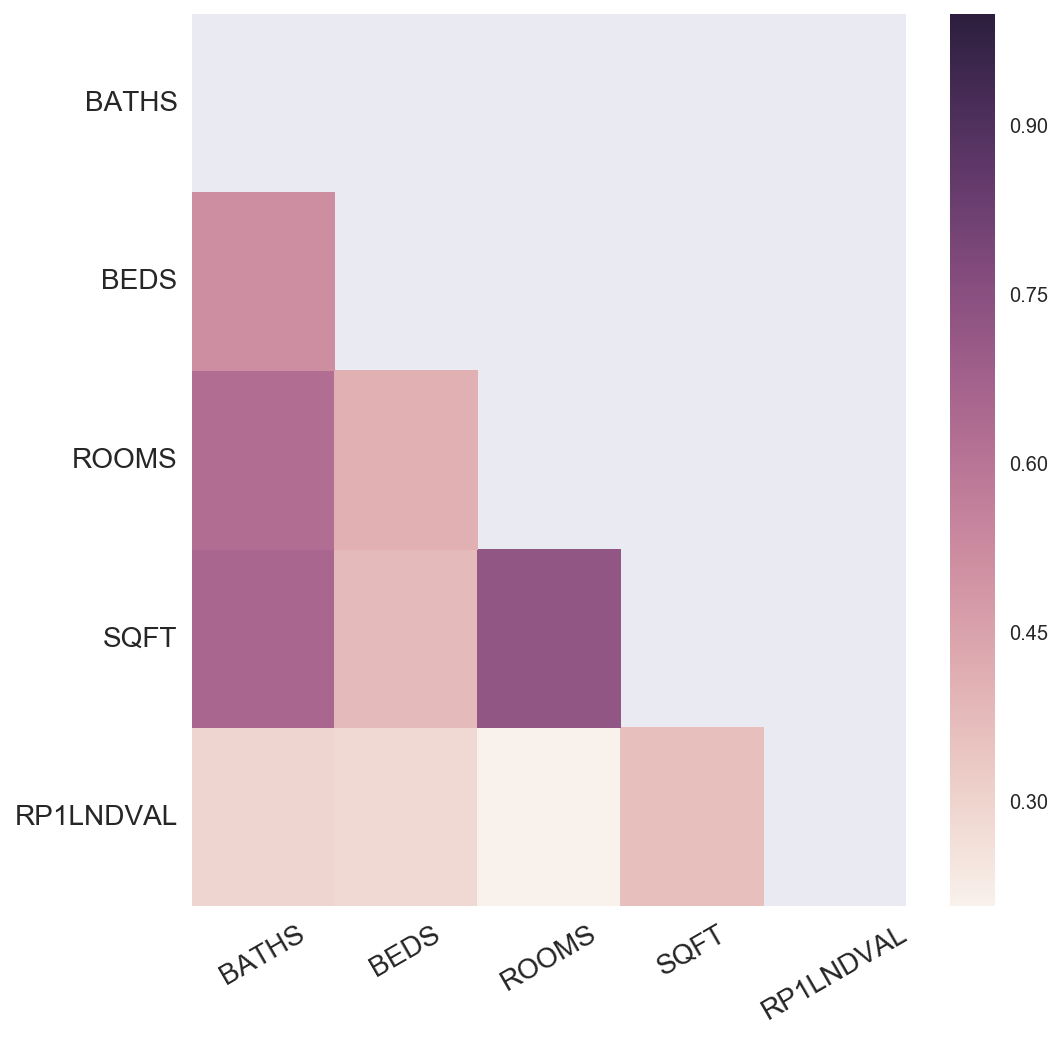

In [18]:
corrs = df3.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(8,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. Construct and evaluate a linear regression model on the data

---

1. State the variables that are predictors in your linear regression and the target variable.
- Investigate and remove any outliers or other problems in your data. _This is a subjective process._
- Construct a linear regression model.
- Evaluate the model. How does the $R^2$ of the overall model compare to cross-validated $R^2$. What do the differences in $R^2$ mean?
  - Use test / train split
  - Use K-Folds
  - Compare and explain your results with both
- Visualize the evaluation metrics of your analysis in clear charts.
- Summarize your results in the context of your hypothesis. Frame this as if you are presenting to non-technical readers.


In [72]:
formula = 'RP1LNDVAL ~ BATHS + BEDS + ROOMS + SQFT'
y, X = patsy.dmatrices(formula,df3,return_type='dataframe')

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.3)

lm = linear_model.LinearRegression()

model = lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
score = lm.score(X_test,y_test)

print 'coef:',lm.coef_
print 'intercept:',lm.intercept_
print 'R^2:',score

cv = cross_validation.cross_val_score(lm,X,y,cv=5)

print 'R^2 w/ cv:' , cv

coef: [[     0.          33406.31354536  42274.41671844 -43373.86947982
     220.46523675]]
intercept: [ 111726.27579025]
R^2: 0.181340240468
R^2 w/ cv: [ 0.13218562  0.11815912  0.1503012  -0.24661448  0.08554107]


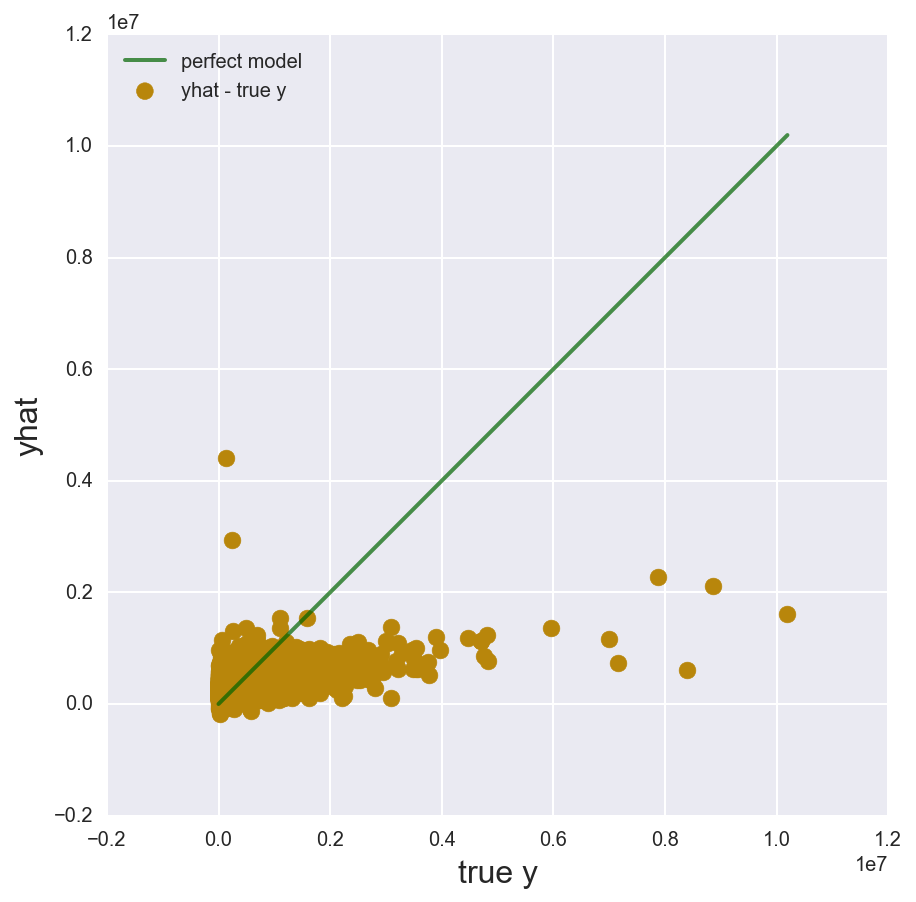

In [73]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca()

ax.scatter(y_test, predictions, color='darkgoldenrod', s=70, label='yhat - true y')

max_x = np.max(y_test)+1

ax.plot([0, max_x], [0, max_x], color='darkgreen',
        linewidth=2.0, alpha=0.7, label='perfect model')

ax.set_xlabel('true y', fontsize=16)
ax.set_ylabel('yhat', fontsize=16)

plt.legend(loc='upper left')

plt.show()

In [ ]:
#My model is.... 

![](https://kreese.files.wordpress.com/2008/07/poop.gif) 

Using test/train/split the R^2 is ~ 0.18. This is a measure of the predictive power of the model with 1 being a model that perfectly predicts the target and 0 being a model that simply guesses the mean(no insight at all) Given the score of 0.18 this means that my model is only slightly better then if I simply took the mean land value for the data set and simply guessed that for every property. Given this the regression model I implemented does not have much predictive power. This is further highligted by the negative R^2 for one of the folds. A negative R^2 means I underperformed simply guessing the average. These low scores mean that we have not identified the features that explain the target and we need to keep exploring new feature sets. 

A few lessons learned from this exercise...
* Using features about a property to predict the land value didn't make a whole lot of sense to begin with. Might be worth digging around more later to understand exactly what these dollar values are. Doesn't seem like actual home values are on here. 
* Land value is all about location location location. Exploring neighborhoods would probably have been a good feature. I need to look more into proper method for using dummy variables. 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2.2 Explain $R^2$ vs. mean squared error (MSE)

---

1. If you have negative $R^2$ values in cross-validation, what does this mean? 
2. Why can $R^2$ only be negative when the model is tested on new data?

1. A negative R^2 means that your model performed worse than the baseline of simply guessing the mean of the target
2. If the data set was 100% random the worst the OLS optimization would do is guess the mean of the data which would 
give an R^2 of 0. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. Combine multiple sources of data and evaluate a model with regularized regression

---

**I recommend having many predictors to see benefits from regularization methods, but it's up to you.**

1. Use _NEW_ sources of data for this section. It should not be related to your analysis/hypothesis from section 1.
- Like in part 1, you should state a hypothesis and perform data cleaning and EDA _only_ on the relevant portions of your data. Don't waste time!
- Construct and evaluate different models with cross-validated $R^2$. Compare LinearRegression, Lasso, Ridge, and ElasticNet. Find the optimal hyperparameters (alpha, l1_ratio) using gridsearch.
- Report on which model is best, and why that might be the case (hint: does your data have multicollinearity? Irrelevant variables? Both?)
- Plot visuals that compare the performance of the four models.


In [3]:
zillow_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/zillow_property_sales/zillow_mediansale_persqft_neighborhood.csv'
food = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/food_inspections/food_inspections_LIVES_standard.csv'
revenue = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/city_spending_revenue/spending_revenue.csv'
health = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/health_care_facilities/health_care_facilities.csv'

fire_inspections_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/fire_inspections.csv'
fire_incidents_fp ='/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/fire_incidents.csv'
fire_violations_fp ='/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/fire_data/sf_firecode_violations.csv'
neighborhood_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/neighborhood_analysis/sf_neighborhood_analysis.csv'
crime_fp = '/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/sf_crime/sfpd_incidents_from2003.csv'


#neighboors = pd.read_csv(neighborhood_fp)
fire = pd.read_csv(fire_incidents_fp)
fire_inspect = pd.read_csv(fire_inspections_fp)
fire_viol = pd.read_csv(fire_violations_fp)

#crime = pd.read_csv(crime_fp)

//anaconda/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11,12,19,44,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
//anaconda/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Going to combine inspection and incident data to see if can build a predictive model around fire damage
inspect_cols = ['Inspection Type','Inspection Type Description','Violation Number','Neighborhood  District']
fire_inspect.loc[:,inspect_cols]

#Creating binary for violations 1 being they had a violation. 
fire_inspect['Violation Number'].fillna(0,inplace=True)
fire_inspect['Violation Number'] = fire_inspect['Violation Number'].map(lambda x: 1 if x!= 0 else 0)

inspect_sum = fire_inspect.groupby(['Neighborhood  District'])[['Violation Number']].agg('sum').reset_index()

#Merge violations per neighborhood with incident data
fire_merged = pd.merge(fire,inspect_sum, how='left', left_on='Neighborhood  District', right_on='Neighborhood  District')
fire_merged.info()
fire_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406736 entries, 0 to 406735
Data columns (total 64 columns):
Incident Number                                 406736 non-null int64
Exposure Number                                 406736 non-null int64
Address                                         406633 non-null object
Incident Date                                   406736 non-null object
Call Number                                     406736 non-null int64
Alarm DtTm                                      406736 non-null object
Arrival DtTm                                    406718 non-null object
Close DtTm                                      406736 non-null object
City                                            405509 non-null object
Zipcode                                         334349 non-null float64
Battalion                                       406736 non-null object
Station Area                                    406207 non-null object
Box                                    

Incident Number  Exposure Number               Address Incident Date  \
0          9030109                0         310 Colon Av.    04/12/2009   
1         13067402                0        20 Lansdale Av    07/18/2013   
2         12044490                0  7th St. / Folsom St.    05/13/2012   
3         13033326                0       2799 Pacific Av    04/09/2013   
4         11101416                0   Polk St. / Pine St.    11/01/2011   

   Call Number              Alarm DtTm            Arrival DtTm  \
0     91020273  04/12/2009 06:09:13 PM  04/12/2009 06:13:45 PM   
1    131990117  07/18/2013 10:32:03 AM  07/18/2013 10:37:15 AM   
2    121340051  05/13/2012 03:55:37 AM  05/13/2012 04:01:57 AM   
3    130990286  04/09/2013 04:34:07 PM  04/09/2013 04:39:31 PM   
4    113050357  11/01/2011 06:07:45 PM  11/01/2011 06:10:17 PM   

               Close DtTm City  Zipcode       ...         \
0  04/12/2009 07:23:13 PM   SF      NaN       ...          
1  07/18/2013 10:39:55 AM   SF      NaN       ...          
2  05/13/2012 04:05:44 AM   SF  94103.0       ...          
3  04/09/2013 05:20:27 PM   SF      NaN       ...          
4  11/01/2011 06:11:09 PM   SF  94109.0       ...          

  Detector Failure Reason Automatic Extinguishing System Present  \
0                     NaN                                    NaN   
1                     NaN                                    NaN   
2                     NaN                                    NaN   
3                     NaN                                    NaN   
4                     NaN                                    NaN   

  Automatic Extinguishing Sytem Type  \
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

   Automatic Extinguishing Sytem Perfomance  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   Automatic Extinguishing Sytem Failure Reason  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   Number of Sprinkler Heads Operating  Supervisor District  \
0                                  NaN                  NaN   
1                                  NaN                  NaN   
2                                  NaN                  6.0   
3                                  NaN                  NaN   
4                                  NaN                  3.0   

   Neighborhood  District                         Location Violation Number  
0                     NaN                              NaN              NaN  
1                     NaN                              NaN              NaN  
2         South of Market  (37.7767460000297, -122.407844)            482.0  
3                     NaN                              NaN              NaN  
4                Nob Hill  (37.7896190000297, -122.420497)            472.0  

[5 rows x 64 columns]

In [5]:
fire_merged['Violation Number'].fillna(0,inplace=True)
merged_cols = ['Violation Number','Battalion','Action Taken Primary','Detector Alerted Occupants','Suppression Units','Suppression Personnel','EMS Units','EMS Personnel','Civilian Fatalities','Property Use','Neighborhood  District','Estimated Property Loss']
mask = (fire_merged['Estimated Property Loss'].isnull())

df_fire = fire_merged.loc[~mask,merged_cols]

In [6]:
df_fire.describe().T

count         mean            std      min   25%  \
Violation Number         125775.0   332.543304     359.776575      0.0  27.0   
Suppression Units        125775.0     2.858374      11.908086      0.0   1.0   
Suppression Personnel    125775.0    10.070268      25.722435      0.0   4.0   
EMS Units                125775.0     0.113616       0.561770      0.0   0.0   
EMS Personnel            125775.0     0.212896       1.198275      0.0   0.0   
Civilian Fatalities      125775.0     0.000191       0.016440      0.0   0.0   
Estimated Property Loss  125775.0  4151.946102  309354.914811 -25000.0   0.0   

                           50%    75%          max  
Violation Number         204.0  489.0       1057.0  
Suppression Units          2.0    3.0       3333.0  
Suppression Personnel      9.0   11.0       4960.0  
EMS Units                  0.0    0.0         72.0  
EMS Personnel              0.0    0.0        286.0  
Civilian Fatalities        0.0    0.0          3.0  
Estimated Property Loss    0.0    0.0  100000000.0

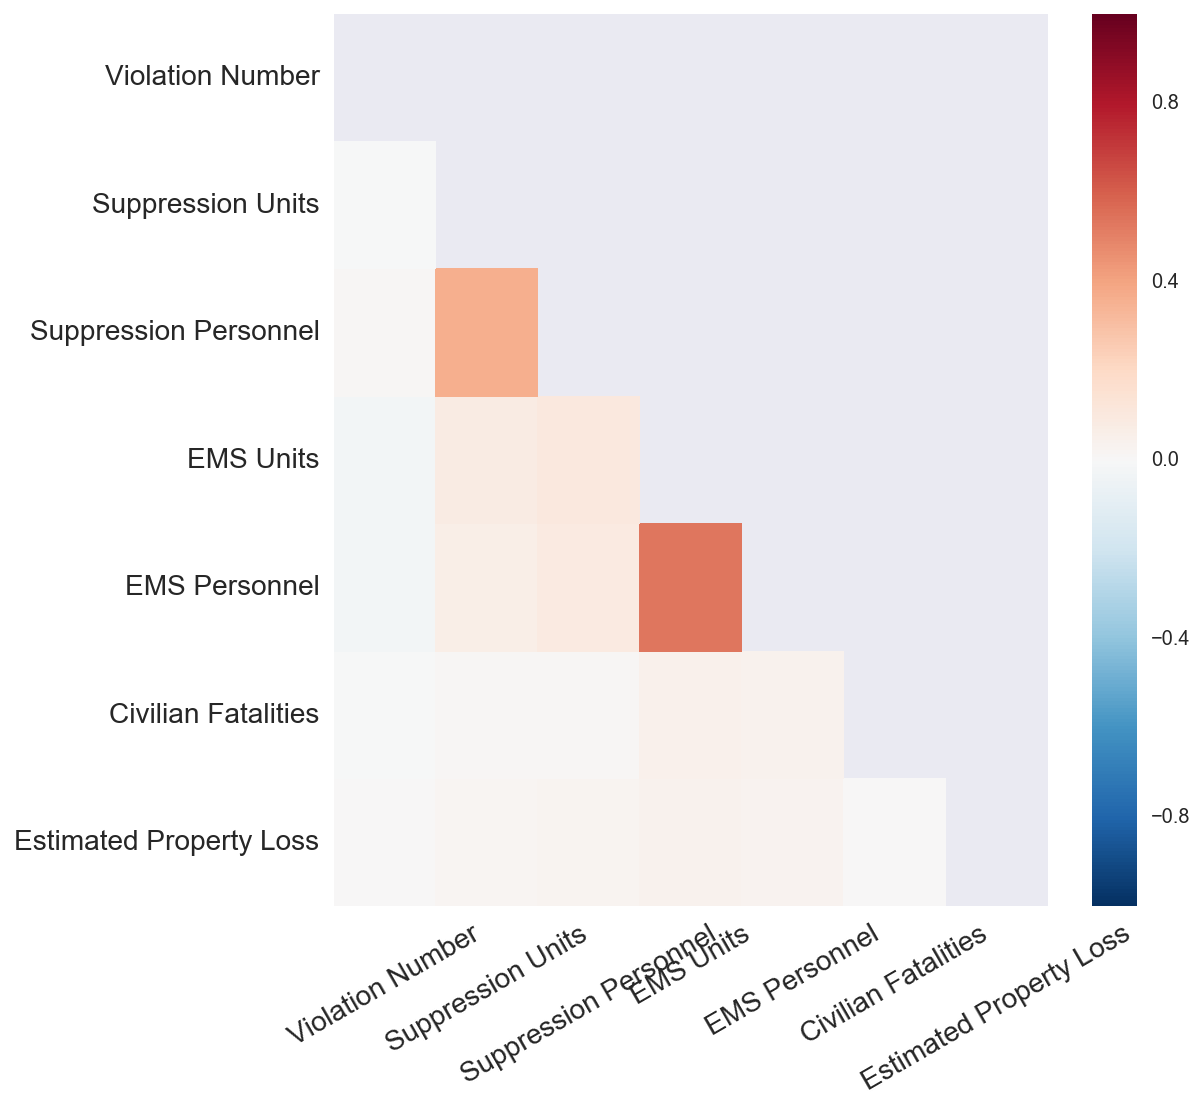

In [7]:
def map_corr(df):
    corrs = df.corr()
    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(8,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
map_corr(df_fire)

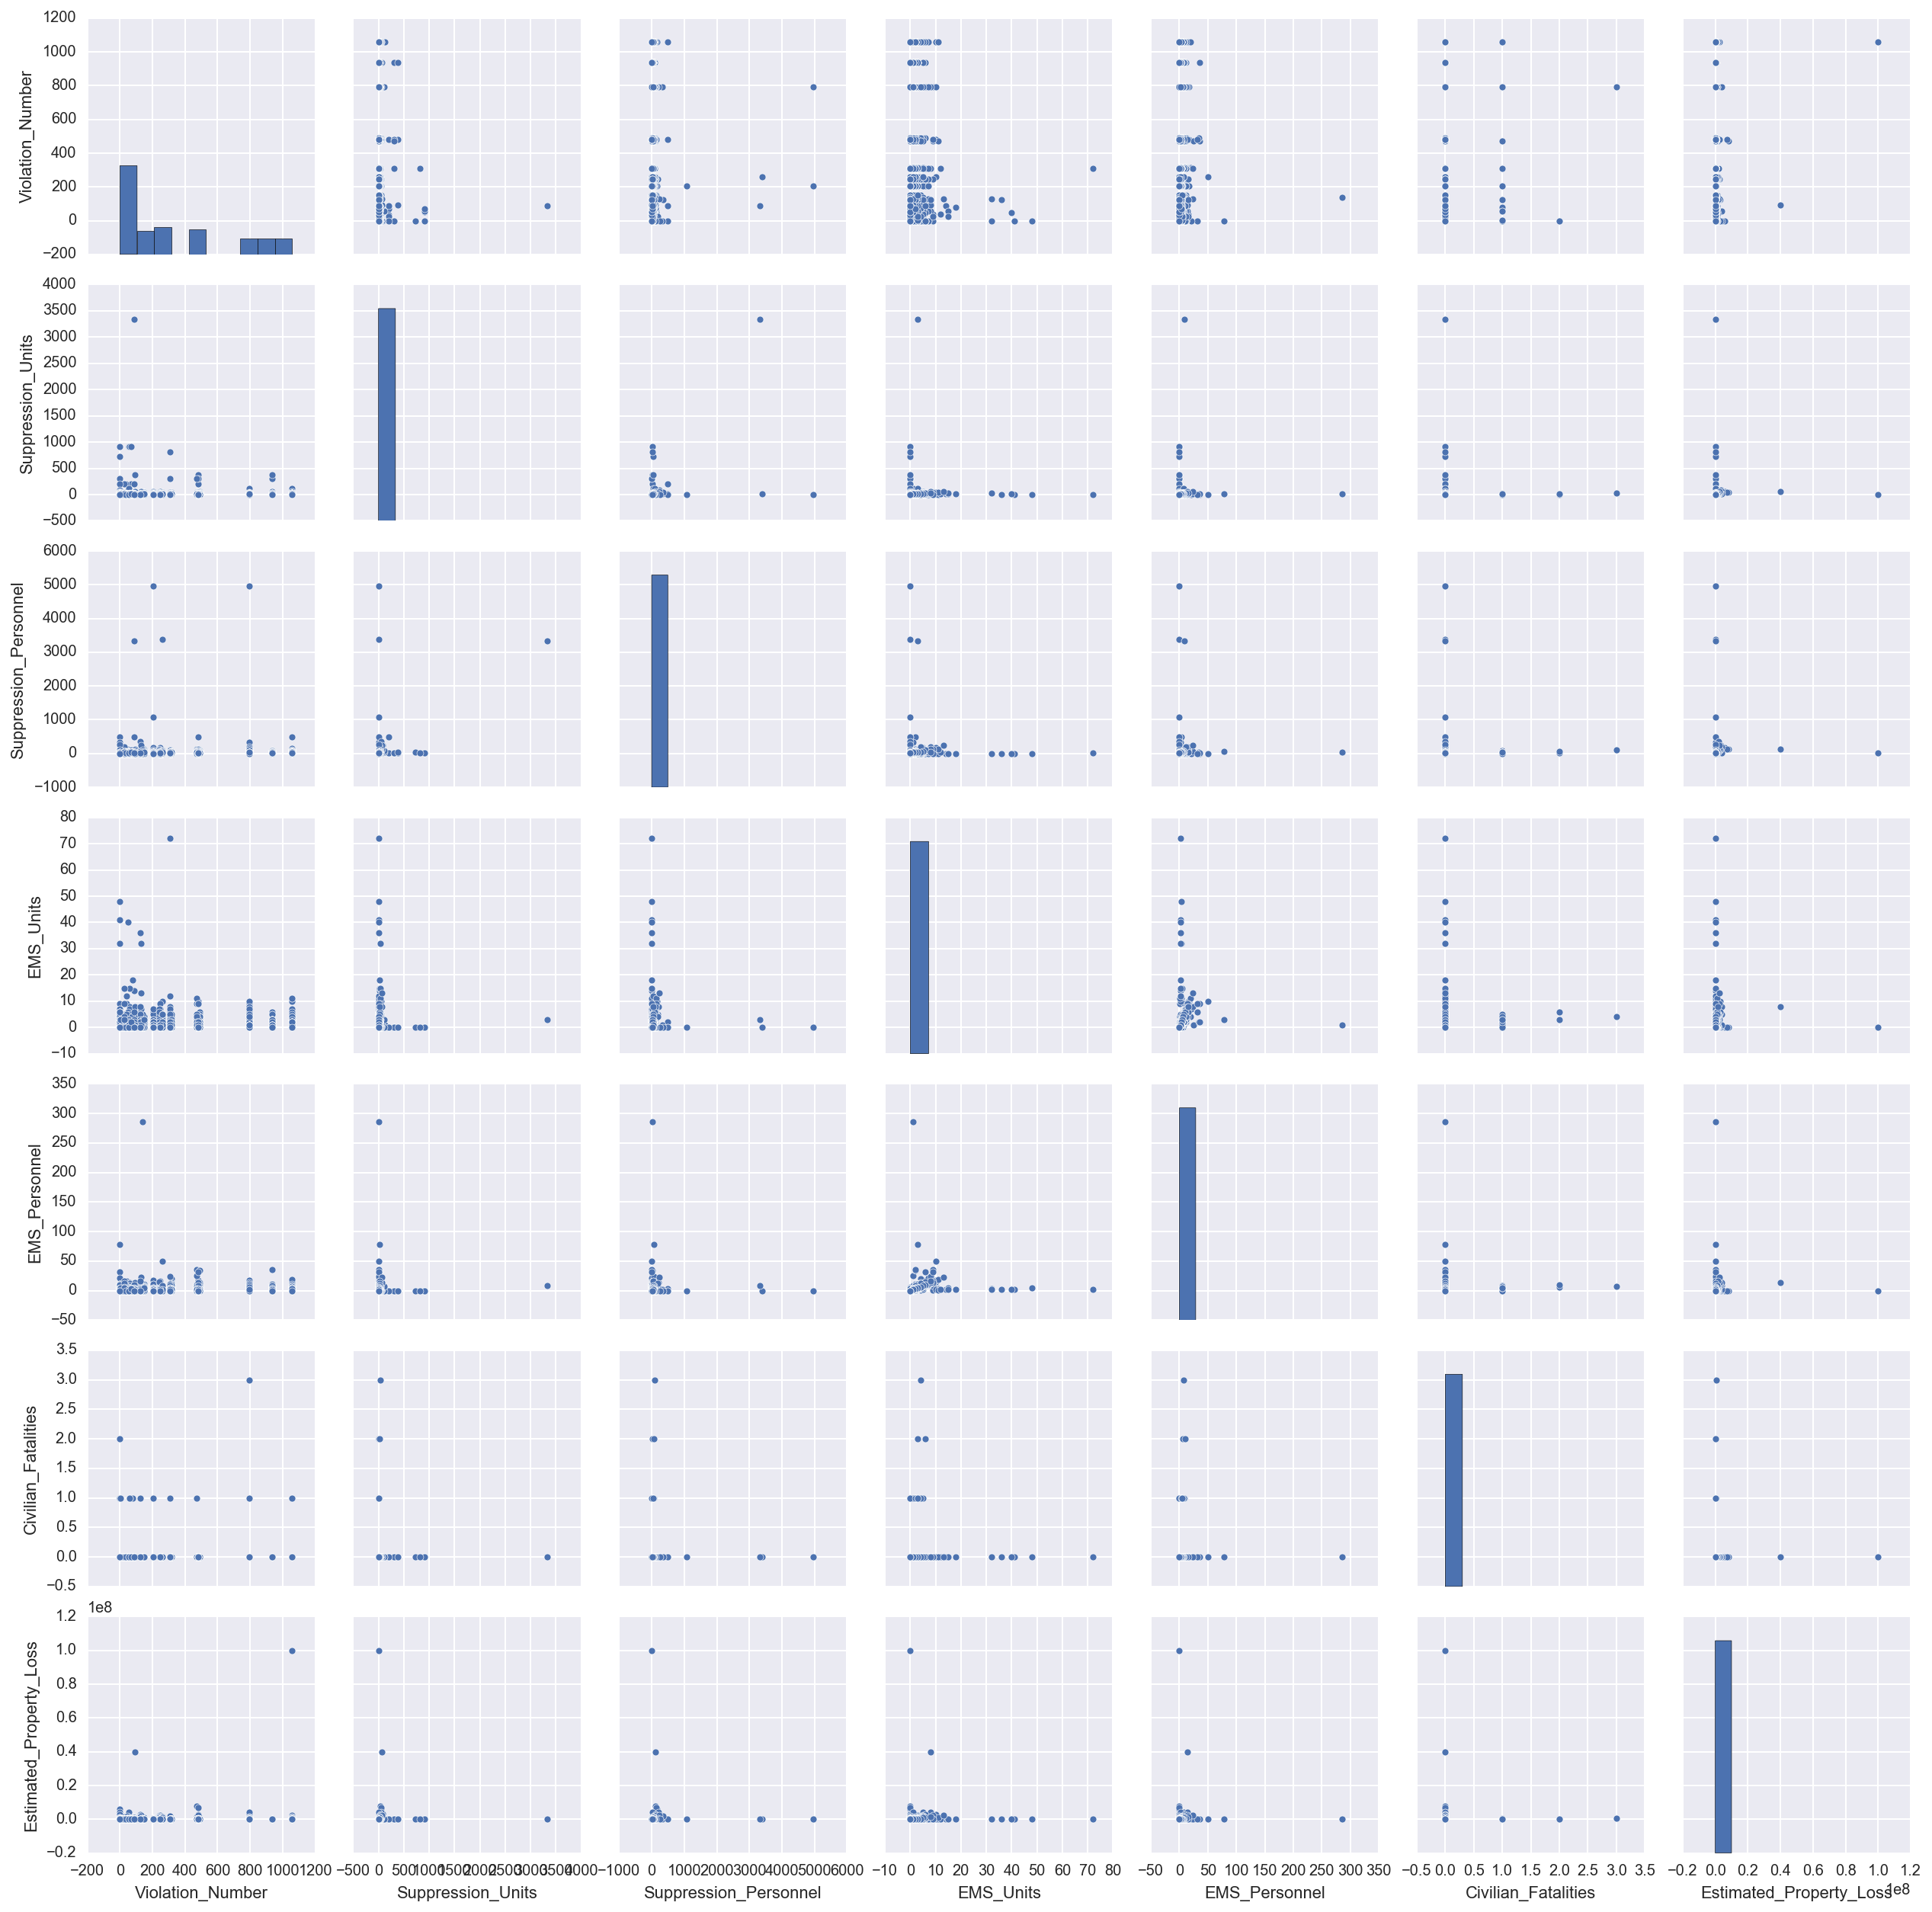

In [19]:
sns.pairplot(df_fire)

In [227]:
print df_fire['Action Taken Primary'].unique()
print df_fire['Detector Alerted Occupants'].unique()
print df_fire['Battalion'].unique()

#Action taken primary has way too many options. Ideally would categorize these into broader categories. For next time..
df_fire.head()

['52 forcible entry' '86 - investigate' '64 - shut down system'
 '93 - cancelled enroute' '70 - assistance, other'
 '63 - restore fire alarm system' '12 - salvage & overhaul'
 '52 - forcible entry' '00 - action taken, other' '11 - extinguish'
 '75 - provide equipment' '71 - assist physically disabled'
 '31 - provide first aid & check for injuries'
 '62 - restore fire protection system' '73 - provide manpower'
 '22 - rescue, remove from harm' '30 - emergency medical services, other'
 '92 - standby' '45 - remove hazard'
 '32 - provide basic life support (bls)' '10 - fire, other'
 '76 - provide water' '40 - hazardous condition, other'
 '23 - extricate, disentangle' '33 - provide advanced life support (als)'
 '43 - hazmat spill control and confinement'
 '61 - restore municipal services' '82 - notify other agencies.'
 '51 - ventilate' '81 - incident command' '65 - secure property'
 '53 - evacuate area' '84 - refer to proper authority'
 '80 - information/invest. & enforcement, other' '66 - r

Violation Number Battalion    Action Taken Primary  \
7               77.0       B08       52 forcible entry   
11             935.0       B03        86 - investigate   
12             489.0       B01        86 - investigate   
14               0.0       B08   64 - shut down system   
15               0.0       B09  93 - cancelled enroute   

            Detector Alerted Occupants  Suppression Units  \
7   2 detector did not alert occupants                  8   
11                                   -                  3   
12                                   -                  2   
14                                   -                  1   
15                                   -                  1   

    Suppression Personnel  EMS Units  EMS Personnel  Civilian Fatalities  \
7                      28          1              2                    0   
11                     10          0              0                    0   
12                      9          0              0                    0   
14                      4          0              0                    0   
15                      5          0              0                    0   

                    Property Use          Neighborhood  District  \
7    161 restaurant or cafeteria                 Sunset/Parkside   
11   429 - multifamily dwellings  Financial District/South Beach   
12            uuu - undetermined                       Chinatown   
14  419 - 1 or 2 family dwelling                             NaN   
15            uuu - undetermined                             NaN   

    Estimated Property Loss  
7                     800.0  
11                      0.0  
12                      0.0  
14                      0.0  
15                      0.0

In [13]:
import patsy 
df_fire.columns = [x.replace(' ','_') for x in df_fire.columns]
X_list = [x for x in df_fire.columns[:-1] if x!= 'Action_Taken_Primary']

#print df_fire.columns
X_cols = ' + '.join(X_list)
target = df_fire.columns[-1]

formula = target + ' ~ ' + X_cols

y,X = patsy.dmatrices(formula,df_fire,return_type='dataframe')

X.head()

Intercept  Battalion[T.B02]  Battalion[T.B03]  Battalion[T.B04]  \
7         1.0               0.0               0.0               0.0   
11        1.0               0.0               1.0               0.0   
12        1.0               0.0               0.0               0.0   
17        1.0               0.0               0.0               0.0   
18        1.0               0.0               0.0               0.0   

    Battalion[T.B05]  Battalion[T.B06]  Battalion[T.B07]  Battalion[T.B08]  \
7                0.0               0.0               0.0               1.0   
11               0.0               0.0               0.0               0.0   
12               0.0               0.0               0.0               0.0   
17               0.0               1.0               0.0               0.0   
18               0.0               0.0               0.0               0.0   

    Battalion[T.B09]  Battalion[T.B10]         ...           \
7                0.0               0.0         ...            
11               0.0               0.0         ...            
12               0.0               0.0         ...            
17               0.0               0.0         ...            
18               0.0               0.0         ...            

    Neighborhood__District[T.Twin Peaks]  \
7                                    0.0   
11                                   0.0   
12                                   0.0   
17                                   0.0   
18                                   0.0   

    Neighborhood__District[T.Visitacion Valley]  \
7                                           0.0   
11                                          0.0   
12                                          0.0   
17                                          0.0   
18                                          0.0   

    Neighborhood__District[T.West of Twin Peaks]  \
7                                            0.0   
11                                           0.0   
12                                           0.0   
17                                           0.0   
18                                           0.0   

    Neighborhood__District[T.Western Addition]  Violation_Number  \
7                                          0.0              77.0   
11                                         0.0             935.0   
12                                         0.0             489.0   
17                                         0.0             794.0   
18                                         0.0             472.0   

    Suppression_Units  Suppression_Personnel  EMS_Units  EMS_Personnel  \
7                 8.0                   28.0        1.0            2.0   
11                3.0                   10.0        0.0            0.0   
12                2.0                    9.0        0.0            0.0   
17                1.0                    5.0        0.0            0.0   
18                2.0                    9.0        0.0            0.0   

    Civilian_Fatalities  
7                   0.0  
11                  0.0  
12                  0.0  
17                  0.0  
18                  0.0  

[5 rows x 311 columns]

In [16]:
lr = linear_model.LinearRegression()
lr_model = lr.fit(X,y)
lr_score = lr.score(X,y)
print 'R^2:',lr_score

#Survey says this model is worse then the last one! Hopefully regularization can help...

R^2: 0.000960592967531


In [20]:
lasso = linear_model.Lasso(normalize=True)
lasso_model = lasso.fit(X,y)
lasso_score = lasso.score(X,y)
print 'R^2:',lasso_score

#Survey says... no help. Model still sucks! That said need to scale variables firsts so still hope???

R^2: 0.000882972878286


In [24]:
ss = preprocessing.StandardScaler()
Xn = ss.fit_transform(X)

lasso = linear_model.Lasso(normalize=True)
lasso_model = lasso.fit(Xn,y)
lasso_score = lasso.score(Xn,y)
print 'R^2:',lasso_score

#Sad face.. will try GridSearch on elastic net just for practice...

R^2: 0.000882972878286


In [31]:
en = linear_model.ElasticNet()
params = {
            'l1_ratio':np.arange(0.1,1,.1),
            'alpha':np.arange(0.1, 1.0, 0.2),
            'normalize':[True,False],
            'fit_intercept':[True,False]    
}

gs = GridSearchCV(en,params,cv=5)
gs_model = gs.fit(X,y)
gs_score = gs.score(X,y)

print gs_score

#note sure why this is taking so long to run. Model is garbage anyways so moving on...

KeyboardInterrupt: 

None of the models are providing anything with any kind of predictive power at all. We are pretty much no better then 
simply guessing the mean. A few thoughts on lessons learned...

* From EDA could see that correlations were tiny between X and Y variables so model never really had a chance
* Large clustering of damage around 0. Probably should have filtered these out somehow. Maybe a more general action taken could have helped here short of simpley removing them. Grouping by this category and looking at count, mean, and std could have helped to identify subsets worth exploring individually. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. Conduct another, different analysis and report on it

---

1. Combining multiple sources of data (csv files) is required.
- Perform EDA and cleaning on relevant data.
- Construct and compare different regression models with cross-validation.
- Plot descriptive visuals you think are useful for understanding the data.
- Report on your findings.

This section is just another analysis like the first sections, but is more open-ended in what models you decide to build and why. Don't feel obligated to try every out every regularized regression model (though it doesn't hurt). 


In [97]:
info = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/parks/park_info.csv')
score = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/parks/park_scores.csv')
donate = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/san_francisco/parks/park_donations.csv')

#10:20 PM Thursday and I'm tired so going to try and keep this one short and sweet. No more trying to figure out 
#plotting maps or playing with shapely and idenifying neighborhoods with lat/long. 

#My hypothesis is that we can use the park type and acreage to predict number of scores.

#First step is to summarize scores data getting number of score per park.
score_count = score.groupby(['ParkID'])[['Score']].agg('count').reset_index()

#Next up is to merge this with info data
#ParkID, Score
parks = pd.merge(info,score_count,how='left',on='ParkID')
df_park = parks.loc[:,['Acreage','ParkType','Score']]

df_park.Score.fillna(0,inplace=True)
df_park.dropna(inplace=True)
df_park.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 1 to 229
Data columns (total 3 columns):
Acreage     229 non-null float64
ParkType    229 non-null object
Score       229 non-null float64
dtypes: float64(2), object(1)
memory usage: 7.2+ KB


In [79]:
formula = 'Score ~ Acreage + ParkType'
y,X = patsy.dmatrices(formula, df_park, return_type = 'dataframe')
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [112]:
en2 = linear_model.ElasticNet()
params = {
            'l1_ratio':np.arange(0.1,1,.1),
            'alpha':np.arange(0.1, 1.0, 0.2),
            'normalize':[True,False],
            'fit_intercept':[True,False]    
}

gs = GridSearchCV(en2,params,cv=5)
gs_model = gs.fit(Xn,y)
gs_score = gs.score(Xn,y)

print gs_score

0.420069391503


In [105]:
df_all = X
df_all['score'] = y

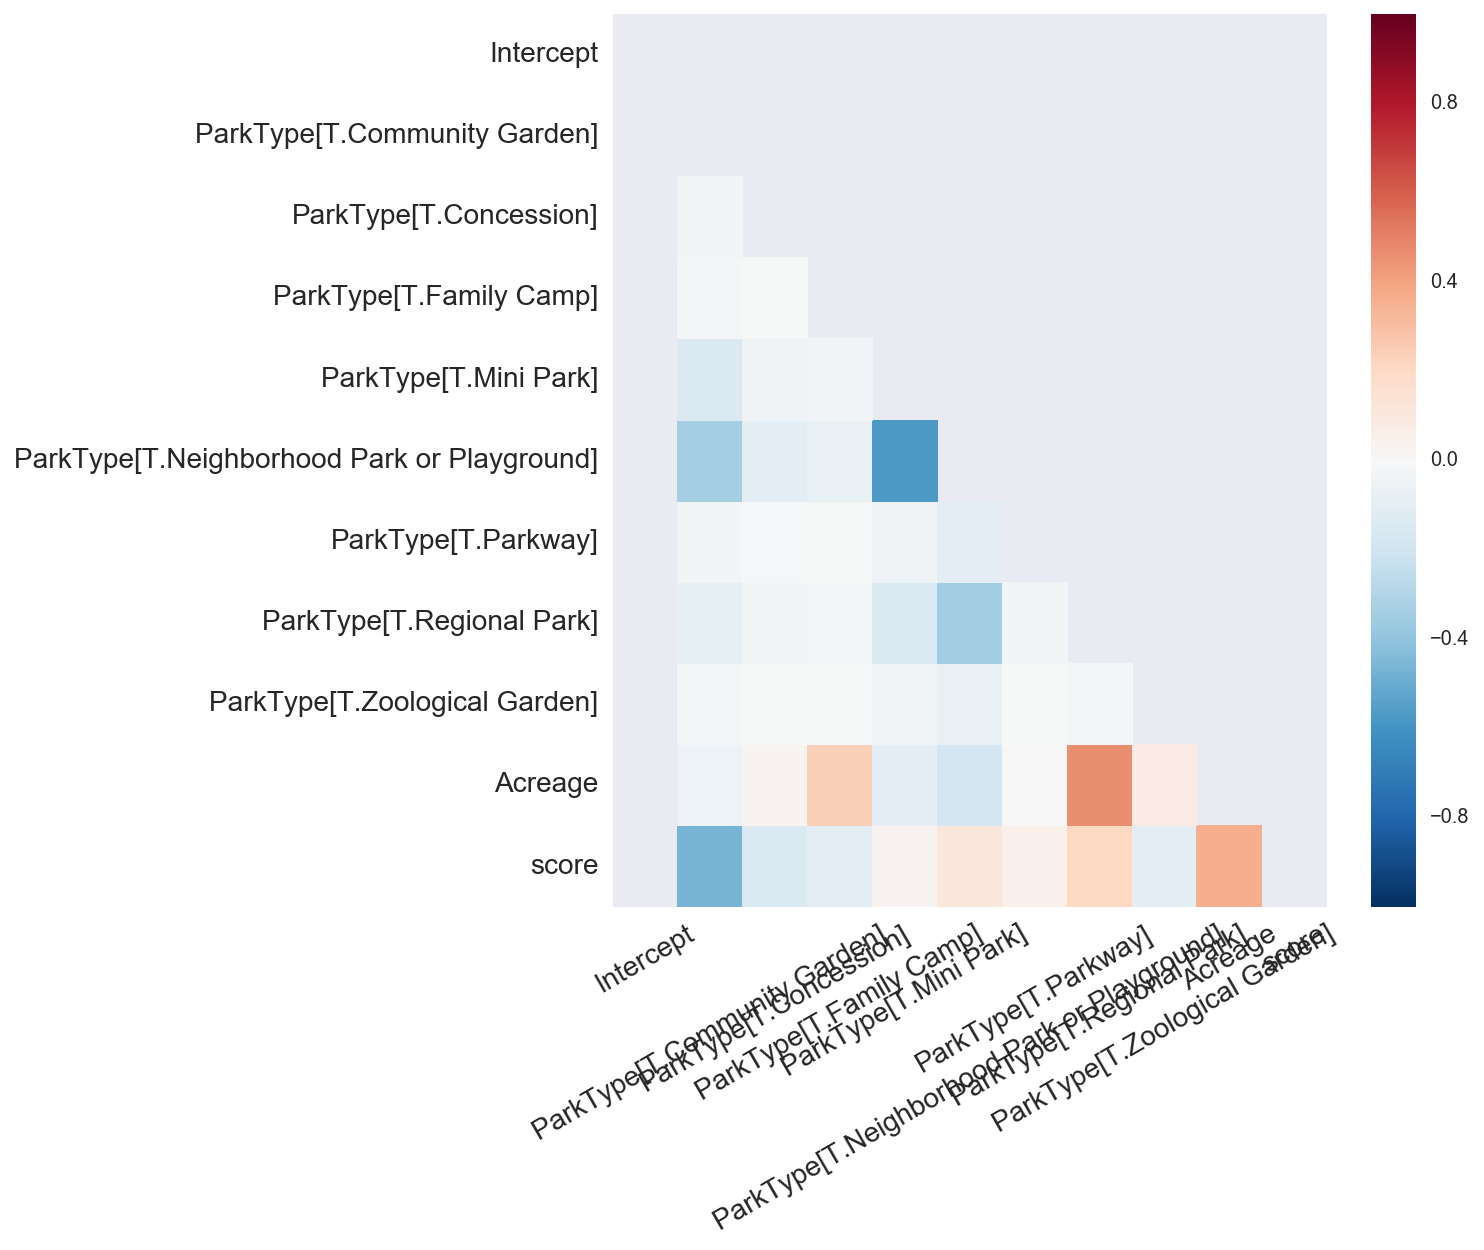

In [108]:
map_corr(df_all)

In [119]:
print gs.best_params_
en3 = linear_model.ElasticNet(alpha=0.30000000000000004,l1_ratio=0.9,normalize=False,fit_intercept=True)
model = en3.fit(Xn,y)
for (name,value) in zip(X.columns, model.coef_):
    print name,value

{'normalize': False, 'alpha': 0.30000000000000004, 'l1_ratio': 0.90000000000000002, 'fit_intercept': True}
Intercept 0.0
ParkType[T.Community Garden] -6.3478512332
ParkType[T.Concession] -2.25729886054
ParkType[T.Family Camp] -2.69327136229
ParkType[T.Mini Park] -0.0
ParkType[T.Neighborhood Park or Playground] 0.0
ParkType[T.Parkway] 0.242948552543
ParkType[T.Regional Park] -0.0
ParkType[T.Zoological Garden] -1.87274014376
Acreage 5.55767685938


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4.2 Ploting GridSearch with Lasso, Ridge, or Elasticnet
---
1. Using the gridsearch results, plot your score in relation to your parameters.
1. Plot the effect on your coefficients given alpha.
1. Plot any other parameter change to visualize the impact of any other hyperparameter.

It's helpful to understand the impact of parameters used in Gridsearch, and that you are comfortable working with the data that is generated for reporting to explore the results visually.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Bias-variance tradeoff

---

1. Select San Francisco data of your choice and construct a regularized regression model (this can be data from an earlier analysis if you like). Ideally the model should actually improve across regularization strengths...
- Gridsearch the regularization parameters to find the optimal.
- Plot the regularization parameter against the cross-validated $R^2$.
- Explain how regularization and regularization strength is related to the bias-variance tradeoff.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Calculate the approximated $\text{bias}^2$ and variance across regularization strengths.

---

You can obviously use my code from the bias-variance lab to do this. 

Plot the bias and variance change _with_ the cross-validated $R^2$. 

You'll need to scale these values somehow to put them on the same chart (I recommend (MinMaxScaler)[http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html] to put $\text{bias}^2$ and variance on the same scale as cross-validated $R^2$.

<img src="http://imgur.com/HNPKfE8.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Custom regularized regression penalties

---

The $\lambda1$ and $\lambda2$ norm regularization penalties (Lasso and Ridge) are the most commonly used regularization penalties. They have a solid foundation in statistics and evidence of effectiveness. However, these are not the only possible penalties for regression – sometimes new, customized penalties give additional performance and predictive power to models depending on the context.

For example, when I worked in neuroscience [we created an effective penalized regression dubbed "GraphNet"](http://arxiv.org/abs/1110.4139) that combined the Lasso and Ridge penalties like in Elastic net with a third penalty that rewarded clustering of coefficients according to physical distance in FMRI brain activation data.

**Devise of and implement a penalized regression for San Francisco data.** What is your rationale – why would this be useful? How does it perform compared to the standard Ridge, Lasso, and Elastic Net penalties?